# Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ALL IMPORTS AND INSTALLS
!pip install gingerit -q
!pip install pymediawiki -q
!pip install pattern3 -q
!sed -i '36s/.*/    pass/' /usr/local/lib/python3.7/dist-packages/pattern3/text/tree.py
from gingerit.gingerit import GingerIt
import json
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import nltk.data
from nltk.tokenize import TreebankWordTokenizer
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import pandas as pd
from mediawiki import MediaWiki
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pattern3.en import lemma
from collections import Counter
from itertools import chain 
import numpy as np
from nltk.stem import PorterStemmer
import re
from gensim.models import Phrases
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('genesis')

     |████████████████████████████████| 23.7MB 59.5MB/s 
     |████████████████████████████████| 419kB 43.6MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 133kB 49.9MB/s 
     |████████████████████████████████| 5.6MB 52.1MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_d

True

In [3]:
path = '/content/drive/MyDrive/Sem-6-Books/CS6370/Project Final Files/' ## Specify path to cran_queries.json, cran_docs.json, cran_qrels.json and other files (from gdrive) here (must be in the same folder)
# LOADING DOCS AND QUERIES-IDs IN A LIST, AND CONTENT IN ANOTHER LIST
docs_json = json.load(open(path + "cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], ['{} {}'.format(item['author'], item["body"]) for item in docs_json]

queries_json = json.load(open(path + "cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# CREATING A DICTIONARY OF DOCUMENT/QUERY IDs AND CONTENT
docs_dict = dict(zip(doc_ids, docs))
queries_dict = dict(zip(query_ids, queries))

qrels = json.load(open(path + "cran_qrels.json", 'r'))[:]

# Plots

Text(0.5, 1.0, 'Distribution of Words in Documents')

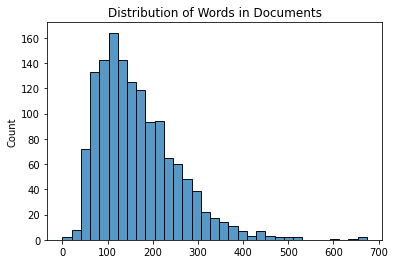

In [4]:
# PLOTTING DISTRIBUTION OF WORDS IN DOCUMENTS
len_docs = []
for doc in docs:
  len_docs.append(len(doc.split()))

sns.histplot(len_docs)
plt.title("Distribution of Words in Documents")

Text(0.5, 1.0, 'Distribution of Words in Queries')

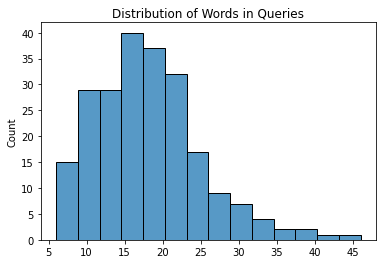

In [5]:
# PLOTTING DISTRIBUTION OF WORDS IN QUERIES
len_query = []
for query in queries:
  len_query.append(len(query.split()))

sns.histplot(len_query)
plt.title("Distribution of Words in Queries")

# Segmentation

In [6]:
def remove_punctuations(textList):
    # textList -> list of docs [doc1, doc2]
    # returns list of cleans docs [doc1, doc2]
    # REMOVES PUNCTUATIONS FROM TEXT
    processedList = []
    for text in textList:
        processedText = text.replace('/', '').replace('-'," ").replace(
                        ",","").replace("("," ").replace(")", " "). replace(
                       "+"," ").replace("\n",' ').replace('"',"").replace(
                        "'","").replace("["," ").replace("]"," ")
        processedList.append(processedText)
    return processedList

def remove_extra_spaces(textList):
    # textList -> list of docs [doc1, doc2]
    # returns list of cleans docs [doc1, doc2]
    # REMOVES EXTRA SPACES, '=' AND EXTRA FULLSTOPS FROM TEXT
    processedList = []
    for text in textList:
        processedText = re.sub('=+', ' ', text)
        processedText = re.sub(' +', ' ', processedText)
        processedText = re.sub(' \.', '.', processedText)
        processedText = re.sub('\.\.+', '.', processedText)
        processedList.append(processedText)
    return processedList

def punkt(textList):
    # textList -> list of docs [doc1, doc2]
    # returns list of list of sentences [[sentence1doc1, sentence2doc1],[sentence1doc2, sentence2doc2]]
    # SEGMENTS DOCUMENTS INTO SENTENCES
    segmentedList = []
    for text in textList:
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        segmentedText = tokenizer.tokenize(text)
        segmentedList.append(segmentedText)
    return segmentedList

# Spellcheck


In [7]:
def spellcheck(segmentedText):
    # segmentedText -> list of list of sentences [[sentence1doc1, sentence2doc1],[sentence1doc2, sentence2doc2]]
    # returns list of list of corrected sentences [[sentence1doc1, sentence2doc1],[sentence1doc2, sentence2doc2]]
    # CORRECTS INCORRECT SPELLINGS AND SPLITS COMPOUND WORDS; DOES INTO CORRECT PROPER NOUNS
    correctedtextlist = []
    for text in tqdm(segmentedText):
        correctedsentencelist = []
        for sentence in tqdm(text):
            try: 
                result = GingerIt().parse(sentence)
                corrections = result['corrections']
                correctText = result['result']
                correctedsentencelist.append(correctText)
            except:
                correctedsentencelist.append(sentence)
        correctedtextlist.append(correctedsentencelist)
    return correctedtextlist

# Tokenization

In [8]:
def pennTreeBank(textList, do_bigram = False):
    # textList -> list of list of sentences [[sentence1doc1, sentence2doc1],[sentence1doc2, sentence2doc2]]
    '''returns list of list of list of words [[[word1sentence1doc1, word2sentence1doc1],
                                                 word1sentence2doc1, word2sentence2doc1]],
                                                 
                                                [[word1sentence1doc2, word2sentence1doc2],
                                                 word1sentence2doc2, word2sentence2doc2]]
    '''
    # TOKENIZES SENTENCES INTO WORDS IF do_bigram == False AND INTO WORDS AND PHRASES if do_bigram == True
    docList = []
    for doc in textList:
        
        sentenceList = []
        for sentence in doc:
            
            treeBank = TreebankWordTokenizer()
            tokenizedText=[sentence[start:end] for start, end in treeBank.span_tokenize(sentence)]
            if do_bigram:
              phraseExtractedText = bigram[tokenizedText]
              sentenceList.append(phraseExtractedText)
            else:
              sentenceList.append(tokenizedText)
        docList.append(sentenceList)
        
    return docList

# Phrase Extraction

In [9]:
# TEXT IN QUERIES AND DOCS ARE COMBINED AND FED TO MODEL TO OBTAIN PHRASES USING NPMI
corpus = " ".join(queries) + " " + " ".join(docs)
c1 = punkt([corpus])
p1 = pennTreeBank(c1, do_bigram=False)
bigram = Phrases(p1[0]) #list of list of words.

# StopWord Removal

In [10]:
def stopwordremoval(textList):
    '''
    textList -> list of list of list of words [[[word1sentence1doc1, word2sentence1doc1],
                                                 word1sentence2doc1, word2sentence2doc1]],
                                                 
                                                [[word1sentence1doc2, word2sentence1doc2],
                                                 word1sentence2doc2, word2sentence2doc2]]
    returns list of list of words (non-stopwords) 
    '''
    # REMOVES STOPWORDS FROM LIST OF LIST OF LIST OF WORDS
    stopWords = stopwords.words('english')
    for i,doc in enumerate(textList):
        for j,sentence in enumerate(doc):
            textList[i][j] = [word.lower() for word in sentence if word not in stopWords ]
    return textList

# Inflection Reduction

In [11]:
def lemmatization(textList):
    '''
    textList -> list of list of list of stopword removed words 
                                                [[[word1sentence1doc1, word2sentence1doc1],
                    
                    word1sentence2doc1, word2sentence2doc1]],
                                                 
                                                [[word1sentence1doc2, word2sentence1doc2],
                                                 word1sentence2doc2, word2sentence2doc2]]
    returns list of list of lemmatized words (non-stopwords) 
    '''
    # LEMMATIZES EACH WORD IN LIST OF LIST OF LIST OF WORDS. PATTERN3 LIBRARY USED SINCE NLTK GAVE INCORRECT RESULTS FOR MANY WORDS. Eg. obeyed
    for i,doc in enumerate(textList):
        for j,sentence in enumerate(doc):
            textList[i][j] = [lemma(word) for word in sentence]
    return textList

def stemming(textList):
  # STEMS EACH WORD IN LIST OF LIST OF LIST OF WORDS. USED FOR EXPERIMENTATION ONLY; UNUSED
    porter=PorterStemmer()
    for i,doc in enumerate(textList):
        for j,sentence in enumerate(doc):
            textList[i][j] = [porter.stem(word) for word in sentence]
    return textList

In [12]:
def fullstopremoval(textList):
    '''
    textList -> list of list of list of lemmatized words 
                                                [[[word1sentence1doc1, word2sentence1doc1],
                                                 word1sentence2doc1, word2sentence2doc1]],
                                                 
                                                [[word1sentence1doc2, word2sentence1doc2],
                                                 word1sentence2doc2, word2sentence2doc2]]
    returns list of list of words with no fullstops as elements
    '''
    # REMOVES FULLSTOPS AND SOME OTHER PUNCTUATIONS PERSISTING AFTER TOKENIZATION
    for i,doc in enumerate(textList):
        for j,sentence in enumerate(doc):
            textList[i][j] = list(filter(lambda x: x not in ['/',',','.',"'", ":", ";"], sentence))
    return textList

# Pipeline

In [13]:
def pipeline(textList, do_spellcheck = False, do_stemming = False, do_bigram=False):
    # textList -> list of documents/queries
    # returns -> list of list of list of words
    # TAKES LIST OF RAW TEXT -> REMOVES PUNCTUATIONS AND SPACES -> SEGMENTED -> TOKENIZED WITH BIGRAMS IF do_bigram==True -> STEMMED/LEMMATIZED -> SPELLCHECK -> REMOVE FULLSTOPS AND PUNCTUATION
    cleanedtext = remove_extra_spaces(remove_punctuations(textList))
    segmentedtext = punkt(cleanedtext)
    tokenizedtext = pennTreeBank(segmentedtext, do_bigram=do_bigram)
    stopwordremovedText = stopwordremoval(tokenizedtext)
    if do_stemming:
        stemmedText = stemming(stopwordremovedText)
        fullstopremovedText = fullstopremoval(stemmedText)
    else:
        lemmatizedText = lemmatization(stopwordremovedText)
        fullstopremovedText = fullstopremoval(lemmatizedText)
    if do_spellcheck: 
        text = spellcheck(fullstopremovedText)
    else: 
        text = fullstopremovedText
    return text

In [14]:
# FUNCTIONS USED TO SAVE AND LOAD VARIOUS FORMATS OF DATA IN BINARY FILES USING PICKLE
def save(filename, variable):
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)
def load(filename):
    with open(filename, 'rb') as fp:
        file = pickle.load(fp)
    return file

In [15]:
# save("cleanDocs5-phrase.pkl", cleanDocs)
# save("cleanQueries5-phrase.pkl", cleanQueries)

# LSA Implementation - A: Checking similarity of dimension reduced queries and docs

In [30]:
#LSA Implementation #Dot Product for Query Implementation  # Both in concept space
#LSA Implementation -1

class InformationRetrieval_3():

    def __init__(self):
        self.index = None
    
    def buildIndex(self, docs, docIDs, queries):
        """
        Builds the document index in terms of the document
        IDs and stores it in the 'index' class variable

        Parameters
        ----------
        arg1 : list
            A list of lists of lists where each sub-list is
            a document and each sub-sub-list is a sentence of the document
        arg2 : list
            A list of integers denoting IDs of the documents
        Returns
        -------
        None
        """
   
        
        index = None
        N = len(docs) #finding the total number of documents
        self.docIDs = docIDs
        
        DF = {} #Dictionary which will contain keys: terms, values: corresponding documents it is present in (Note: These are not the document IDs as we are interested in number of docs and not the specific docs)
        for i in range(len(docs)):
            for j in range(len(docs[i])):
                for k in docs[i][j]:
            
                    try:
                        DF[k].add(i)
                    except:
                        DF[k] = {i}
        
        #Finding the document frequency of each unique term
        for i in DF:
            DF[i] = len(DF[i])
        self.DF = DF #Now, DF is a dictionary with key = unique terms, value = document frequency
        
        #list of unique terms in considering all the docs
        term_list = list(DF.keys())
        self.term_list = term_list
        
        #list of documnent frequencies of the terms
        df = list()
        for i in range(len(DF)):
            df.append(DF[self.term_list[i]])
        self.df = df
        
        #Finding the inverse document frequencies
        idf = np.log((np.array(N))/(np.array(self.df)))
        self.idf = idf
   

        #Computing the term-document matrix   
        TermDoc_matrix = np.zeros((len(DF),len(docs))) 
        for i in range(len(docs)):       
            for j in range(len(docs[i])):  
                for word in docs[i][j]:
                    try:
                        TermDoc_matrix[self.term_list.index(word),i] += 1
                    except:
                        dummy_var = 0
        
        self.TermDoc_matrix = TermDoc_matrix
        
                
        #Computing the document vectors
        self.doc_vectors = np.zeros((len(self.term_list),len(docs)))
        for i in range(len(self.term_list)):
            self.doc_vectors[i,:] = self.idf[i]*TermDoc_matrix[i,:] 
        
        #TFIDF MATRIX WITH TERMS AS ROWS AND COUMNS AS DOCS
        self.tfidf_matrix = self.doc_vectors
            
        # Dictionary with keys:doc_IDs and values as doc vectors
        index = {key: None for key in docIDs}  
        for i in range(len(docs)):
            index[docIDs[i]] = self.doc_vectors[:,i] 

        #Building the Query-Term Matrix
        term_queries_matrix = np.zeros((len(self.term_list), len(queries)))
        for i in range(len(queries)):
            for j in range(len(queries[i])):
                for word in queries[i][j]:
                    try:
                        term_queries_matrix[self.term_list.index(word), i] +=1
                    except:
                        dummy_var = 0
        
        self.term_queries_matrix = term_queries_matrix
        # TF-IDF representation of the queries 
        term_queries_tfidf_matrix = np.zeros((len(self.term_list),len(queries)))
        for i in range(len(self.term_list)):
            term_queries_tfidf_matrix[i,:] = self.idf[i]*term_queries_matrix[i,:]
                        
        #Term- Query Matrix
        self.term_queries_tfidf_matrix = term_queries_tfidf_matrix

        # Dictionary with keys:doc_IDs and values as doc vectors
        self.index = index

    def lsa(self, tfidf_mat, K=600):

  

      P,Q = np.shape(tfidf_mat)

      #[term_concept, self.concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #self.term_concept = term_concept[:, 0:1400]
      #self.concept_doc = concept_doc[0:1400, :]

      [term_concept, concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #capturing 99% variance
      self.term_concept = term_concept[:, 0:K]
      self.concept_doc = concept_doc[0:K, :]
      self.concept_strengths = np.diag(concept_strengths[0:K])
      concept_strengths_inv = 1/concept_strengths
      self.concept_strengths_inv = np.diag(concept_strengths_inv[0:K])

      self.reduced_term_doc_matrix = np.matmul(self.term_concept, np.matmul(self.concept_strengths, self.concept_doc))


      #Docs in concept space
      lsa_doc_dict = {lsa_doc_dict: [] for lsa_doc_dict in range(Q)} #Dictionary with keys as doc_ids and their respective concepts
      #doc_rep = self.concept_doc.T
      #doc_rep = (np.dot(self.concept_strengths, self.concept_doc)).T
      doc_rep = np.matmul(self.concept_strengths_inv, np.matmul(self.term_concept.T, self.tfidf_matrix) )
      for i in range(Q):
        lsa_doc_dict[i]= doc_rep[:,i]
      
      self.lsa_doc_dict = lsa_doc_dict

      #Terms in concept space # This part is right
      lsa_term_dict = {lsa_term_dict: [] for lsa_term_dict in self.term_list} #Dictionary with terms as doc_ids and terms as concepts
      #term_rep = self.term_concept
      term_rep = np.dot(self.term_concept, self.concept_strengths)
      for i in range(P):
        lsa_term_dict[self.term_list[i]]= term_rep[i,:]
      
      self.term_dict = lsa_term_dict


   # Queries in terms of concepts
    def relevance(self, queries):

      
      #Get queries in terms of concepts
       #query_concept_matrix = np.matmul(self.term_queries_tfidf_matrix.T, np.matmul(self.term_concept, self.concept_strengths))
       query_concept_matrix = np.matmul(self.concept_strengths_inv, np.matmul(self.term_concept.T, self.term_queries_tfidf_matrix) )
       query_concept_dict = {query_concept_dict: [] for query_concept_dict in range(len(queries))}
       for i in range(len(queries)):
         query_concept_dict[i] = query_concept_matrix[:,i]
      
       self.query_concept_dict = query_concept_dict

       #Find the cosine similarity of each query with each of the documents(in concept space) and rank them
       doc_IDs_ordered  = [None]*len(queries)
       for i in range(len(queries)):
         cosine_similarities = {key: None for key in self.docIDs} 
         for j in range(len(self.index)):
           #x = self.lsa_doc_dict[j]
           x = self.query_concept_dict[i]
           y = self.lsa_doc_dict[j]
           cosine_similarities[self.docIDs[j]] = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)) #computing the cosine similarities between query and all the document vectors
                #cosine_similarities[j] = self.query_concept_dict[i][j]
         rank_cosine_similarities = sorted(cosine_similarities.items(), key = lambda kv: kv[1],reverse = True) #sorting the docs based on predicted order of relevance
         doc_IDs_ordered[i] = [k[0] for k in rank_cosine_similarities] #adding the list of docs in the predicted order of relevance for the ith query

      #Rank and return the doc_IDs_ordered
       self.doc_IDs_ordered = doc_IDs_ordered


        #Extract the terms in a sublist and find their corresponding vector in concept space. Then find the centroid. Do this for all the sub-lists
      
      #query_concept_dict = {query_concept_dict: [] for query_concept_dict in range(len(queries))}
      #for i in range(len(queries)):
        #lists=[]
        #for j in range(len(queries[i])):
           #for k in range(len(queries[i][j])):
             #if (queries[i][j][k] in self.term_list):
              #t_vec = self.term_dict[queries[i][j][k]]
              #lists.append(t_vec)
             #else:
               #t_vec = np.zeros(1400)
               #lists.append(t_vec)
        #query_concept = np.mean(np.array(lists), axis=0)
        #query_concept_dict[i] = query_concept

      #self.query_concept_dict = query_concept_dict



# LSA Implementation - B: Checking similarity of query and document in original space with intermediate concept space mapping; Part 1: Query Dot Product

In [27]:
#LSA Implementation #Dot Product for Query Implementation 
#LSA Implementation -1

class InformationRetrieval_1():

    def __init__(self):
        self.index = None
    
    def buildIndex(self, docs, docIDs, queries):
        """
        Builds the document index in terms of the document
        IDs and stores it in the 'index' class variable

        Parameters
        ----------
        arg1 : list
            A list of lists of lists where each sub-list is
            a document and each sub-sub-list is a sentence of the document
        arg2 : list
            A list of integers denoting IDs of the documents
        Returns
        -------
        None
        """
   
        
        index = None
        N = len(docs) #finding the total number of documents
        self.docIDs = docIDs
        
        DF = {} #Dictionary which will contain keys: terms, values: corresponding documents it is present in (Note: These are not the document IDs as we are interested in number of docs and not the specific docs)
        for i in range(len(docs)):
            for j in range(len(docs[i])):
                for k in docs[i][j]:
            
                    try:
                        DF[k].add(i)
                    except:
                        DF[k] = {i}
        
        #Finding the document frequency of each unique term
        for i in DF:
            DF[i] = len(DF[i])
        self.DF = DF #Now, DF is a dictionary with key = unique terms, value = document frequency
        
        #list of unique terms in considering all the docs
        term_list = list(DF.keys())
        self.term_list = term_list
        
        #list of documnent frequencies of the terms
        df = list()
        for i in range(len(DF)):
            df.append(DF[self.term_list[i]])
        self.df = df
        
        #Finding the inverse document frequencies
        idf = np.log((np.array(N))/(np.array(self.df)))
        self.idf = idf
   

        #Computing the term-document matrix   
        TermDoc_matrix = np.zeros((len(DF),len(docs))) 
        for i in range(len(docs)):       
            for j in range(len(docs[i])):  
                for word in docs[i][j]:
                    try:
                        TermDoc_matrix[self.term_list.index(word),i] += 1
                    except:
                        dummy_var = 0
        
        self.TermDoc_matrix = TermDoc_matrix
        
                
        #Computing the document vectors
        self.doc_vectors = np.zeros((len(self.term_list),len(docs)))
        for i in range(len(self.term_list)):
            self.doc_vectors[i,:] = self.idf[i]*TermDoc_matrix[i,:] 
        
        #TFIDF MATRIX WITH TERMS AS ROWS AND COUMNS AS DOCS
        self.tfidf_matrix = self.doc_vectors
            
        # Dictionary with keys:doc_IDs and values as doc vectors
        index = {key: None for key in docIDs}  
        for i in range(len(docs)):
            index[docIDs[i]] = self.doc_vectors[:,i] 

        #Building the Query-Term Matrix
        term_queries_matrix = np.zeros((len(self.term_list), len(queries)))
        for i in range(len(queries)):
            for j in range(len(queries[i])):
                for word in queries[i][j]:
                    try:
                        term_queries_matrix[self.term_list.index(word), i] +=1
                    except:
                        dummy_var = 0
        
        self.term_queries_matrix = term_queries_matrix
        # TF-IDF representation of the queries 
        term_queries_tfidf_matrix = np.zeros((len(self.term_list),len(queries)))
        for i in range(len(self.term_list)):
            term_queries_tfidf_matrix[i,:] = self.idf[i]*term_queries_matrix[i,:]
                        
        #Term- Query Matrix
        self.term_queries_tfidf_matrix = term_queries_tfidf_matrix

        # Dictionary with keys:doc_IDs and values as doc vectors
        self.index = index

    def lsa(self, tfidf_mat, K=700):

  

      P,Q = np.shape(tfidf_mat)

      #[term_concept, self.concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #self.term_concept = term_concept[:, 0:1400]
      #self.concept_doc = concept_doc[0:1400, :]

      [term_concept, concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #capturing 99% variance
      self.term_concept = term_concept[:, 0:K]
      self.concept_doc = concept_doc[0:K, :]
      self.concept_strengths = np.diag(concept_strengths[0:K])

      self.reduced_term_doc_matrix = np.matmul(self.term_concept, np.matmul(self.concept_strengths, self.concept_doc))


      #Docs in concept space
      lsa_doc_dict = {lsa_doc_dict: [] for lsa_doc_dict in range(Q)} #Dictionary with keys as doc_ids and their respective concepts
      #doc_rep = self.concept_doc.T
      doc_rep = (np.dot(self.concept_strengths, self.concept_doc)).T
      for i in range(Q):
        lsa_doc_dict[i]= doc_rep[i,:]
      
      self.lsa_doc_dict = lsa_doc_dict

      #Terms in concept space # This part is right
      lsa_term_dict = {lsa_term_dict: [] for lsa_term_dict in self.term_list} #Dictionary with terms as doc_ids and terms as concepts
      #term_rep = self.term_concept
      term_rep = np.dot(self.term_concept, self.concept_strengths)
      for i in range(P):
        lsa_term_dict[self.term_list[i]]= term_rep[i,:]
      
      self.term_dict = lsa_term_dict


   # Queries in terms of concepts
    def relevance(self, queries):

      
      #Get queries in terms of concepts
       query_concept_matrix = np.matmul(self.term_queries_tfidf_matrix.T, np.matmul(self.term_concept, self.concept_strengths))
       query_concept_dict = {query_concept_dict: [] for query_concept_dict in range(len(queries))}
       for i in range(len(queries)):
         query_concept_dict[i] = query_concept_matrix[i,:]
      
       self.query_concept_dict = query_concept_dict

       #Find the cosine similarity of each query with each of the documents(in concept space) and rank them
       doc_IDs_ordered  = [None]*len(queries)
       for i in range(len(queries)):
         cosine_similarities = {key: None for key in self.docIDs} 
         for j in range(len(self.index)):
           #x = self.lsa_doc_dict[j]
           x = self.query_concept_dict[i]
           y = self.lsa_doc_dict[j]
           cosine_similarities[self.docIDs[j]] = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)) #computing the cosine similarities between query and all the document vectors
                #cosine_similarities[j] = self.query_concept_dict[i][j]
         rank_cosine_similarities = sorted(cosine_similarities.items(), key = lambda kv: kv[1],reverse = True) #sorting the docs based on predicted order of relevance
         doc_IDs_ordered[i] = [k[0] for k in rank_cosine_similarities] #adding the list of docs in the predicted order of relevance for the ith query

      #Rank and return the doc_IDs_ordered
       self.doc_IDs_ordered = doc_IDs_ordered


        #Extract the terms in a sublist and find their corresponding vector in concept space. Then find the centroid. Do this for all the sub-lists
      
      #query_concept_dict = {query_concept_dict: [] for query_concept_dict in range(len(queries))}
      #for i in range(len(queries)):
        #lists=[]
        #for j in range(len(queries[i])):
           #for k in range(len(queries[i][j])):
             #if (queries[i][j][k] in self.term_list):
              #t_vec = self.term_dict[queries[i][j][k]]
              #lists.append(t_vec)
             #else:
               #t_vec = np.zeros(1400)
               #lists.append(t_vec)
        #query_concept = np.mean(np.array(lists), axis=0)
        #query_concept_dict[i] = query_concept

      #self.query_concept_dict = query_concept_dict



# LSA Implementation - B: Checking similarity of query and document in original space with intermediate concept space mapping; Part 2: Query Centroid

In [28]:
# LSA Implementation #Centroid Implementation

class InformationRetrieval_2():

    def __init__(self):
        self.index = None
    
    def buildIndex(self, docs, docIDs, queries):
        """
        Builds the document index in terms of the document
        IDs and stores it in the 'index' class variable

        Parameters
        ----------
        arg1 : list
            A list of lists of lists where each sub-list is
            a document and each sub-sub-list is a sentence of the document
        arg2 : list
            A list of integers denoting IDs of the documents
        Returns
        -------
        None
        """
   
        
        index = None
        N = len(docs) #finding the total number of documents
        self.docIDs = docIDs
        
        DF = {} #Dictionary which will contain keys: terms, values: corresponding documents it is present in (Note: These are not the document IDs as we are interested in number of docs and not the specific docs)
        for i in range(len(docs)):
            for j in range(len(docs[i])):
                for k in docs[i][j]:
            
                    try:
                        DF[k].add(i)
                    except:
                        DF[k] = {i}
        
        #Finding the document frequency of each unique term
        for i in DF:
            DF[i] = len(DF[i])
        self.DF = DF #Now, DF is a dictionary with key = unique terms, value = document frequency
        
        #list of unique terms in considering all the docs
        term_list = list(DF.keys())
        self.term_list = term_list
        
        #list of documnent frequencies of the terms
        df = list()
        for i in range(len(DF)):
            df.append(DF[self.term_list[i]])
        self.df = df
        
        #Finding the inverse document frequencies
        idf = np.log((np.array(N))/(np.array(self.df)))
        self.idf = idf
   

        #Computing the term-document matrix   
        TermDoc_matrix = np.zeros((len(DF),len(docs))) 
        for i in range(len(docs)):       
            for j in range(len(docs[i])):  
                for word in docs[i][j]:
                    try:
                        TermDoc_matrix[self.term_list.index(word),i] += 1
                    except:
                        dummy_var = 0
        
        self.TermDoc_matrix = TermDoc_matrix
        
                
        #Computing the document vectors
        self.doc_vectors = np.zeros((len(self.term_list),len(docs)))
        for i in range(len(self.term_list)):
            self.doc_vectors[i,:] = self.idf[i]*TermDoc_matrix[i,:] 
        
        #TFIDF MATRIX WITH TERMS AS ROWS AND COUMNS AS DOCS
        self.tfidf_matrix = self.doc_vectors
            
        # Dictionary with keys:doc_IDs and values as doc vectors
        index = {key: None for key in docIDs}  
        for i in range(len(docs)):
            index[docIDs[i]] = self.doc_vectors[:,i] 

        #Building the Query-Term Matrix
        term_queries_matrix = np.zeros((len(self.term_list), len(queries)))
        for i in range(len(queries)):
            for j in range(len(queries[i])):
                for word in queries[i][j]:
                    try:
                        term_queries_matrix[self.term_list.index(word), i] +=1
                    except:
                        dummy_var = 0
        
        self.term_queries_matrix = term_queries_matrix
        # TF-IDF representation of the queries 
        term_queries_tfidf_matrix = np.zeros((len(self.term_list),len(queries)))
        for i in range(len(self.term_list)):
            term_queries_tfidf_matrix[i,:] = self.idf[i]*term_queries_matrix[i,:]
                        
        #Term- Query Matrix
        self.term_queries_tfidf_matrix = term_queries_tfidf_matrix

        # Dictionary with keys:doc_IDs and values as doc vectors
        self.index = index

    def lsa(self, tfidf_mat, K):

  

      P,Q = np.shape(tfidf_mat)

      #[term_concept, self.concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #self.term_concept = term_concept[:, 0:1400]
      #self.concept_doc = concept_doc[0:1400, :]

      
      [term_concept, concept_strengths, concept_doc] = np.linalg.svd(tfidf_mat, full_matrices=False)
      #capturing 99% variance
      self.term_concept = term_concept[:, 0:K]
      self.concept_doc = concept_doc[0:K, :]
      self.concept_strengths = np.diag(concept_strengths[0:K])

      self.reduced_term_doc_matrix = np.matmul(self.term_concept, np.matmul(self.concept_strengths, self.concept_doc))


      #Docs in concept space
      lsa_doc_dict = {lsa_doc_dict: [] for lsa_doc_dict in range(Q)} #Dictionary with keys as doc_ids and their respective concepts
      #doc_rep = self.concept_doc.T
      doc_rep = (np.dot(self.concept_strengths, self.concept_doc)).T
      for i in range(Q):
        lsa_doc_dict[i]= doc_rep[i,:]
      
      self.lsa_doc_dict = lsa_doc_dict

      #Terms in concept space # This part is right
      lsa_term_dict = {lsa_term_dict: [] for lsa_term_dict in self.term_list} #Dictionary with terms as doc_ids and terms as concepts
      #term_rep = self.term_concept
      term_rep = np.dot(self.term_concept, self.concept_strengths)
      for i in range(P):
        lsa_term_dict[self.term_list[i]]= term_rep[i,:]
      
      self.term_dict = lsa_term_dict


   # Queries in terms of concepts
    def relevance(self, queries):
      # self.docIDs = doc_ids
      query_concept_dict = {query_concept_dict: [] for query_concept_dict in range(len(queries))}
      for i in range(len(queries)):
        lists=[]
        for j in range(len(queries[i])):
           for k in range(len(queries[i][j])):
             if (queries[i][j][k] in self.term_list):
              t_vec = self.term_dict[queries[i][j][k]]
              lists.append(t_vec)
        query_concept = np.mean(np.array(lists), axis=0)
        query_concept_dict[i] = query_concept

      self.query_concept_dict = query_concept_dict

#Find the cosine similarity of each query with each of the documents(in concept space) and rank them
      doc_IDs_ordered  = [None]*len(queries)
      for i in range(len(queries)):
        cosine_similarities = {key: None for key in self.docIDs} 
        for j in range(len(self.docIDs)):
          x = self.query_concept_dict[i]
          y = self.lsa_doc_dict[j]
          cosine_similarities[self.docIDs[j]] = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)) #computing the cosine similarities between query and all the document vectors
          self.cosine_similarities = cosine_similarities     
        rank_cosine_similarities = sorted(cosine_similarities.items(), key = lambda kv: kv[1],reverse = True) #sorting the docs based on predicted order of relevance
        doc_IDs_ordered[i] = [k[0] for k in rank_cosine_similarities] #adding the list of docs in the predicted order of relevance for the ith query

        #Rank and return the doc_IDs_ordered
      self.doc_IDs_ordered = doc_IDs_ordered


        #Extract the terms in a sublist and find their corresponding vector in concept space. Then find the centroid. Do this for all the sub-lists
      
      
       

# LSA Experiments

In [32]:
def lsa_call(cleanDocs, doc_ids, cleanQueries, R, K=500): #function that takes in initialised information retrieval objects and performs LSA computaion
  R.buildIndex(cleanDocs,doc_ids, cleanQueries)     
  R.lsa(R.tfidf_matrix, K) 
  R.relevance(cleanQueries)

cleanDocs = pipeline(docs,do_spellcheck=False, do_bigram=False) # Documents and queries cleaned without phrases being extracted
cleanQueries = pipeline(queries, do_spellcheck = False, do_bigram=False)

cleanDocs_bigram = pipeline(docs,do_spellcheck=False, do_bigram=True) # Documents and queries cleaned with phrases being extracted
cleanQueries_bigram = pipeline(queries, do_spellcheck = False, do_bigram=True)

fd = open(path+'reduced_docs.txt', 'r') # Documents and queries cleaned using Punkt and PennTreeBank only; from previous Assignment
fq = open(path+'reduced_queries.txt', 'r')
reducedDocs = eval(fd.read())
reducedQueries = eval(fq.read())

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
R_list = [InformationRetrieval_1()]*3 + [InformationRetrieval_2()]*3 #Initialising a list of 6 IR objects, 3 each of IR1 and IR2 for the 3 kinds of pre-processing
doc_list = [cleanDocs, cleanDocs_bigram, reducedDocs]*2 #List containing docs cleaned using 3 kinds of pre-processing twice, once for each LSA implementation - IR1 and IR2
query_list = [cleanQueries, cleanQueries_bigram, reducedQueries]*2
for i in range(len(R_list)):
  lsa_call(doc_list[i], doc_ids, query_list[i], R_list[i]) # does LSA computation for each of the 6 objects

# ESA

In [ ]:
# index -> {title : list of list of words}
wk = MediaWiki()
df = pd.read_csv(path+"ESA_articles_500_depth-1.csv", index_col="number") #file containing 500 article names relevant to Aerodynamics
df.title = df.title.str.replace('_',' ')
articles = df.title.values # list of all article names
index = {}
for num,title in tqdm(enumerate(articles)):
  try:
    c = wk.page(title)
    article = "{}\n{}\n{}".format(c.content, c.links, c.backlinks)
    cleanedArticle = pipeline([article], do_bigram=True)
    index[title] = cleanedArticle
  except:
    pass

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
def convert_list_to_dict(index, docs_or_queries = False): 
    #converts list of list of list of words n articles to a dictionary of dictionary of article name: {words : num of occurences in article} for faster computation
    fast_index = {}
    for title in tqdm(index): 
        article = index[title]
        if docs_or_queries: #if doc or query is fed as a string, it is passed through pipeline to generate list of list of list of words
            article = pipeline([article])
        article_dict = dict(Counter(list(chain.from_iterable(chain.from_iterable(article))))) #dictionary with tokens as keys and number of occurences as values
        fast_index[title] = article_dict
    return fast_index # returns dictionary of dictionaries
# index = load(path+"index3343-phrases.pkl")  ##uncomment if ESA with 3343 articles is to be used
fi = convert_list_to_dict(index)

In [ ]:
def get_all_tokens(fast_index, with_occurence = False):
    list_dict = fast_index.values()
    all_tokens_dict = dict(sum((Counter(e) for e in list_dict), Counter()))
    ## dictionary of all tokens in all articles as keys and total number of occurences in all articles as values
    if with_occurence:
      return all_tokens_dict
    all_tokens = list(all_tokens_dict.keys())
    return all_tokens #returns all tokens in a list

def create_term_article_matrix(index):
    # returns matrix with terms as row headings and article names as column headings with term frequencies as entries             
    fast_index = convert_list_to_dict(index)
    articles = list(index.keys())
    terms = get_all_tokens(fast_index)
    matrix = pd.DataFrame(0,index = terms, columns = articles) # initializes a term document matrix with 0 entries 
    for term in tqdm(terms): 
        for article in articles:
            if term in fast_index[article]:
                matrix.loc[term,article]+=fast_index[article][term] #adds number of occurences of term in article to 0 entry initialized earlier
    return matrix   

In [ ]:
matrix = create_term_article_matrix(index)
# matrix = pd.read_csv(path+"term-article-matrix-2_phrase-3343.csv", index_col="Unnamed: 0") ## uncomment if 3343 article ESA is to be tested
matrix.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Apollo program  Apollo 12  ...  Flight 404  .17 Bumble Bee
the                 151         61  ...          25               1
apollo              311        209  ...           0               0
program             147         54  ...           0               0
also                 22          8  ...           8               0
know                  6         11  ...           1               0

[5 rows x 3371 columns]

In [ ]:
num_articles_occured = matrix.astype(bool).sum(axis=1)
num_articles = matrix.shape[1]
IDF = np.log(num_articles/num_articles_occured)
tf_idf_matrix = matrix.mul(IDF, axis=0)
tf_idf_matrix.head()

In [ ]:
def compute_centroid(fi_docs):
    ## takes each word in doc or query, finds tf-idf vector and centroid of all
    ## vectors weighted by number of occurences
    
    # fi_docs -> dictionary of dictionaries such that key is doc-id and and inner dict 
    # has terms as keys and num occurences as values
    centroid = {}
    for doc in fi_docs:
        term_dict = fi_docs[doc]
        vector_add = 0 
        total_count = 0
        for term in term_dict:
            try:
                vec = matrix.loc[term].values
                count = term_dict[term]
            except KeyError: # if term in doc or query is not present in any of the articles it is ignored
                vec = 0
                count = 0
              
            vector_add += vec*count # the contribution of the term vector to the query/document vector is weighted by the number of times it occurs 
            total_count += count
        if total_count == 0:
          print("No terms match", doc, docs_dict[doc], term_dict)
          centroid[doc] = np.zeros(matrix.shape[1]) #if none of the terms in the query or document are present in any of the articles then it is represented as a 0 vector in the article space
          continue
        centroid[doc] = vector_add/total_count
    return centroid

In [ ]:
fi_docs = convert_list_to_dict(docs_dict, docs_or_queries=True) #DOCS AND QUERIES ARE CONVERTED FROM DICTIONARY OF DOC-ID/QUERY-ID: STRING TO DICT OF DICTS WITH NUMBER OF OCCURENCES OF TOKENS
fi_queries = convert_list_to_dict(queries_dict, docs_or_queries=True)
# save("fi_queries-3_phrases.pkl",fi_queries)
# save("fi_docs-3_phrases.pkl",fi_docs)

In [ ]:
qc = compute_centroid(fi_queries) # COMPUTES CENTROID OF ALL QUERIES AND DOCS IN ARTICLE SPACE
dc = compute_centroid(fi_docs)

No terms match 471   {}
No terms match 995   {}


In [ ]:
def compute_relevant_docs(query_centroid, docs_centroid): 
  # FINDS COSINE SIMILARITY OF EACH QUERY VECTOR WITH ALL DOCUMENT VECTORS AND RANKS THEM 
  query_vectors = np.array(list(query_centroid.values()))
  doc_vectors = np.array(list(docs_centroid.values()))
  query_doc_similarity = cosine_similarity(query_vectors, doc_vectors)
  qd_sim_df = pd.DataFrame(query_doc_similarity, columns = np.arange(1,len(docs_centroid)+1))
  qd_sim_df = qd_sim_df.set_index(keys=np.arange(1,len(query_centroid)+1))
  return qd_sim_df

In [ ]:
sim_df = compute_relevant_docs(qc,dc) #DataFrame of shape (225, 1400) containing similarity of query with docs
sim_df.head()

1         2         3     ...      1398      1399      1400
1  0.645855  0.563526  0.410487  ...  0.578582  0.645905  0.289510
2  0.636963  0.465359  0.306433  ...  0.576476  0.557382  0.313819
3  0.421591  0.498491  0.405438  ...  0.367541  0.451658  0.278613
4  0.672256  0.831311  0.795284  ...  0.578157  0.685362  0.372586
5  0.626713  0.592380  0.407852  ...  0.636904  0.663807  0.652830

[5 rows x 1400 columns]

In [ ]:
results_df = pd.DataFrame(sim_df.columns[np.argsort(-sim_df.values, axis=1)], columns = np.arange(1,sim_df.shape[1]+1)) # DataFrame containing document IDs along rows in order of relevance to query 
results_df.index = np.arange(1,len(queries)+1)
results_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


1     2     3     4     5     6     ...  1395  1396  1397  1398  1399  1400
1      51   878  1144  1164    29   102  ...  1400  1359   594  1358   471   995
2    1169    12   810   253   374   806  ...  1358   507  1153   594   995   471
3       5   158  1178   399   982   485  ...    65   714   795   594   471   995
4     167   236   317    34   979   375  ...  1359   510  1358   594   995   471
5     367  1032   368   961    62  1102  ...   795   714    65   594   995   471
..    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
221     3   310   941   388   775  1081  ...  1359   718   594  1358   471   995
222   400   736    15   392  1370   425  ...   795  1359   510   594   471   995
223   400   408    15   388   393   736  ...   510   718  1359  1358   995   471
224   317   540   167   236  1222    34  ...  1359   795  1358   594   471   995
225   415  1124   945   198   986  1136  ...   795    65  1358   594   995   471

[225 rows x 1400 columns]

In [ ]:
results = results_df.to_numpy()

# Evaluation

In [33]:
def get_ground_truth(query_id, qrels, relevance=False):
    # RETURNS RELEVANT DOCUMENTS IN A LIST IF relevance == False AND IN A DICT WITH RELEVANCE VALUES = 5 - 'position' IF relevance == True
    rel_docs = {
        int(dic['id']):5-int(dic['position'])
        for dic in qrels
        if int(dic['query_num']) == int(query_id)
    }
    rel_docs_1 = sorted(rel_docs.items(), key=lambda item: item[1])
    if not relevance:
        return [(x[0]) for x in rel_docs_1]
    else:
        return rel_docs

In [34]:
class Evaluation():
  # EVALUATION CODE USED FROM ASSIGNMENT-2 WITH CORRECTED nDCG
	def queryPrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		
		"""
		Computation of precision of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The precision value as a number between 0 and 1
		"""
		# print("query_doc_IDs_ordered[:k]", query_doc_IDs_ordered[:k])
		# print("true_doc_IDs", true_doc_IDs)
		# print("set", set(query_doc_IDs_ordered[:k]).intersection(set(true_doc_IDs)))
		num_returned_relevant = len(set(query_doc_IDs_ordered[:k]).intersection(set(true_doc_IDs)))
		precision = num_returned_relevant / len(query_doc_IDs_ordered[:k])
		# print("in query precision", precision)
		return precision


	def meanPrecision(self, doc_IDs_ordered, query_ids, qrels, k):
		"""
		Computation of precision of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The mean precision value as a number between 0 and 1
		"""
		precision_list = []
		
		for i, query_id in enumerate(query_ids):
			predicted = doc_IDs_ordered[i]
			ground_truth = get_ground_truth(query_id, qrels)
			# print("ground truth is", ground_truth)
			precision = self.queryPrecision(predicted, query_id, ground_truth, k)
			precision_list.append(precision)
		
		meanPrecision = sum(precision_list)/len(precision_list)
		# print(meanPrecision)
		return meanPrecision

	
	def queryRecall(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of recall of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The recall value as a number between 0 and 1
		"""

		

		#Fill in code here
		num_returned_relevant = len(set(query_doc_IDs_ordered[:k]).intersection(set(true_doc_IDs)))
		recall = num_returned_relevant/len(true_doc_IDs)
		# print(recall)
		return recall


	def meanRecall(self, doc_IDs_ordered, query_ids, qrels, k):
		# sourcery skip
		"""
		Computation of recall of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The mean recall value as a number between 0 and 1
		"""
		recall_list = []
		for i, query_id in enumerate(query_ids):
			predicted = doc_IDs_ordered[i]
			ground_truth = get_ground_truth(query_id, qrels)
			recall = self.queryRecall(predicted, query_id, ground_truth, k)
			recall_list.append(recall)
		
		meanRecall = sum(recall_list)/len(recall_list)
		
		# print(meanRecall)
		#Fill in code here

		return meanRecall


	def queryFscore(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		# sourcery skip
		"""
		Computation of fscore of the Information Retrieval System
		at a given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The fscore value as a number between 0 and 1
		"""

		precision = self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
		recall = self.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
		# print("fscore precision", precision)
		# print("fscore recall", recall)
		if precision == 0 or recall == 0:
			fscore = 0
		else:
			fscore = 2*precision*recall/(precision + recall)

		#Fill in code here

		return fscore


	def meanFscore(self, doc_IDs_ordered, query_ids, qrels, k):
		# sourcery skip
		"""
		Computation of fscore of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value
		
		Returns
		-------
		float
			The mean fscore value as a number between 0 and 1
		"""
		fscore_list = []
		for i, query_id in enumerate(query_ids):
			predicted = doc_IDs_ordered[i]
			ground_truth = get_ground_truth(query_id, qrels)
			fscore = self.queryFscore(predicted, query_id, ground_truth, k)
			fscore_list.append(fscore)
		
		meanFscore = sum(fscore_list)/len(fscore_list)
		

		#Fill in code here

		return meanFscore
	

	def queryNDCG(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		"""
		Computation of nDCG of the Information Retrieval System
		at given value of k for a single query

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of IDs of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The nDCG value as a number between 0 and 1
		"""
		relevance_dic = get_ground_truth(query_id, self.qrels, relevance=True)
		pred_relevance_list = []
		
		for doc_id in query_doc_IDs_ordered:
			if doc_id in relevance_dic:
				pred_relevance_list.append(relevance_dic[doc_id])
			else:
				pred_relevance_list.append(0)
		
		# print("pred_relevance_list", pred_relevance_list)

		dcg = 0
		###calculating dcg
		for i, rel_i in enumerate(pred_relevance_list[:k], start=1):
			dcg += rel_i / math.log((i + 1), 2)
		
		### calculating idcg
		relevance_list = list(relevance_dic.items())
		sorted_relevance_list = sorted(relevance_list, key=lambda x: x[1], reverse=True)
		ranked_true_docs = [i[1] for i in sorted_relevance_list]
		true_relevance_list = ranked_true_docs[:k]
		idcg = 0
		for i, rel_i in enumerate(true_relevance_list, start=1):
			idcg += rel_i / math.log((i + 1), 2)

		if idcg==0 or dcg==0:
			nDCG = 0
		else:
			nDCG = dcg / idcg

		return nDCG


	def meanNDCG(self, doc_IDs_ordered, query_ids, qrels, k):
		# sourcery skip
		"""
		Computation of nDCG of the Information Retrieval System
		at a given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries for which the documents are ordered
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
		"Query":query_ids,	The k value

		Returns
		-------
		float
			The mean nDCG value as a number between 0 and 1
		"""
		self.qrels = qrels
		ndcg_list = []
		for i, query_id in enumerate(query_ids):
			true_doc_IDs = get_ground_truth(query_id,qrels)
			ndcg = self.queryNDCG(doc_IDs_ordered[i], query_id, true_doc_IDs, k)
			ndcg_list.append(ndcg)

		meanNDCG = sum(ndcg_list) / len(ndcg_list)
		return meanNDCG


	def queryAveragePrecision(self, query_doc_IDs_ordered, query_id, true_doc_IDs, k):
		# sourcery skip
		"""
		Computation of average precision of the Information Retrieval System
		at a given value of k for a single query (the average of precision@i
		values for i such that the ith document is truly relevant)

		Parameters
		----------
		arg1 : list
			A list of integers denoting the IDs of documents in
			their predicted order of relevance to a query
		arg2 : int
			The ID of the query in question
		arg3 : list
			The list of documents relevant to the query (ground truth)
		arg4 : int
			The k value

		Returns
		-------
		float
			The average precision value as a number between 0 and 1
		"""
		# precision_at_i =[]
		# for i, doc_id in enumerate(query_doc_IDs_ordered, start=1):
		# 	if doc_id in true_doc_IDs:
		# 		precision = self.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, i)
		# 		precision_at_i.append(precision)
		# print("precision_at_i",precision_at_i)
		# avgPrecision = sum(precision_at_i)/len(precision_at_i)
		# print("avgPrecision", avgPrecision)
		
		# return avgPrecision
		num_relevant = 0
		precision_at_i = []
		
		for i,docID in enumerate(query_doc_IDs_ordered[:k],start=1):
			if docID in true_doc_IDs:
				num_relevant += 1
				precision_at_i.append(num_relevant / i)
				
		if num_relevant == 0:
			avgPrecision = 0
		else:    
			avgPrecision = sum(precision_at_i)/num_relevant     
		
		return avgPrecision


	def meanAveragePrecision(self, doc_IDs_ordered, query_ids, q_rels, k):
		# sourcery skip
		"""
		Computation of MAP of the Information Retrieval System
		at given value of k, averaged over all the queries

		Parameters
		----------
		arg1 : list
			A list of lists of integers where the ith sub-list is a list of IDs
			of documents in their predicted order of relevance to the ith query
		arg2 : list
			A list of IDs of the queries
		arg3 : list
			A list of dictionaries containing document-relevance
			judgements - Refer cran_qrels.json for the structure of each
			dictionary
		arg4 : int
			The k value

		Returns
		-------
		float
			The MAP value as a number between 0 and 1
		"""
		average_precision_list = []
		for i, query_id in enumerate(query_ids, start=1):
			predicted = doc_IDs_ordered[i-1]
			ground_truth = get_ground_truth(query_id, q_rels)
			avg_precision = self.queryAveragePrecision(predicted, query_id, ground_truth, k)
			average_precision_list.append(avg_precision)
		
		# print("precision_list",average_precision_list)
		meanAveragePrecision = sum(average_precision_list)/len(average_precision_list)
		
		

		return meanAveragePrecision



# Main

In [35]:
# PRECISION AND RECALL VALUES FOR VSM FROM ASSIGNMENT-2
vsm_recalls = [0.09280259921632467, 0.14596145402690358, 0.173425038022604, 0.20106436298031982, 0.21877414714562513, 0.24190596005723236, 0.2564135142314532, 0.27048124716463584, 0.28341181791359754, 0.2964155055839518]
vsm_precisions = [0.5422222222222223, 0.4488888888888889, 0.373333333333333, 0.33111111111111113, 0.2960000000000004, 0.2755555555555554, 0.25460317460317494, 0.23833333333333334, 0.22222222222222243, 0.21066666666666686]

## Best LSA with cleanDocs with phrases at K=600

In [74]:
R = InformationRetrieval_1()
lsa_call(cleanDocs_bigram, doc_ids, cleanQueries, R, K=600)
results = R.doc_IDs_ordered
title = 'Implementation-1 AugTok with Phrases'

Precision, Recall and F-score @ 1 : 0.5422222222222223, 0.09051851425063052, 0.14899460297059022
MAP, nDCG @ 1 : 0.5422222222222223, 0.42777777777777776
Precision, Recall and F-score @ 2 : 0.47555555555555556, 0.15442779205869123, 0.21902658954047974
MAP, nDCG @ 2 : 0.6111111111111112, 0.4084505971507555
Precision, Recall and F-score @ 3 : 0.42666666666666675, 0.20754560408374867, 0.25966697947095163
MAP, nDCG @ 3 : 0.63, 0.3934242388204669
Precision, Recall and F-score @ 4 : 0.3888888888888889, 0.24843331768985302, 0.2812755702232438
MAP, nDCG @ 4 : 0.633827160493827, 0.3896355936653917
Precision, Recall and F-score @ 5 : 0.35555555555555596, 0.27786987554013654, 0.2883825382795364
MAP, nDCG @ 5 : 0.6252283950617283, 0.3875906520209672
Precision, Recall and F-score @ 6 : 0.33037037037037015, 0.30244161272500153, 0.2919611270619101
MAP, nDCG @ 6 : 0.6108617283950615, 0.3898272977431116
Precision, Recall and F-score @ 7 : 0.30539682539682567, 0.3243776538081012, 0.29053848650297287
MAP,

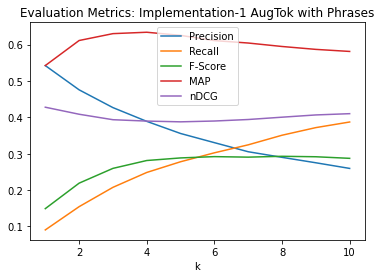

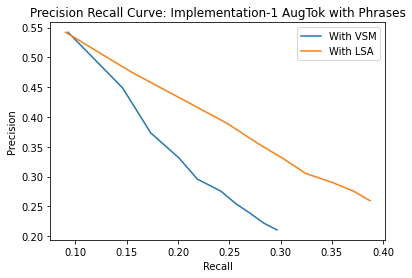

In [75]:
doc_IDs_ordered = results ##################### pass Doc_IDS_ordered
# Read relevance judements
qrels = json.load(open(path + "cran_qrels.json", 'r'))[:]
evaluator = Evaluation()
# Calculate precision, recall, f-score, MAP and nDCG for k = 1 to 10
precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []
for k in range(1, 11):
  precision = evaluator.meanPrecision(
    doc_IDs_ordered, query_ids, qrels, k)
  precisions.append(precision)
  recall = evaluator.meanRecall(
    doc_IDs_ordered, query_ids, qrels, k)
  recalls.append(recall)
  fscore = evaluator.meanFscore(
    doc_IDs_ordered, query_ids, qrels, k)
  fscores.append(fscore)

  print("Precision, Recall and F-score @ " +  
    str(k) + " : " + str(precision) + ", " + str(recall) + 
    ", " + str(fscore))
  MAP = evaluator.meanAveragePrecision(
    doc_IDs_ordered, query_ids, qrels, k)
  MAPs.append(MAP)
  nDCG = evaluator.meanNDCG(
    doc_IDs_ordered, query_ids, qrels, k)
  nDCGs.append(nDCG)
  
  print("MAP, nDCG @ " +  
    str(k) + " : " + str(MAP) + ", " + str(nDCG))
metric_table = pd.DataFrame({"Precision@k":precisions, "Recall@k":recalls, "Fscore@k":fscores,
                              "nDCG@k":nDCGs, "MAP@k":MAPs}, index=np.arange(1,11))   
# for k = 10 finding all metrics for each query
k = 10
precision_q_list, recall_q_list, fscore_q_list, ndcg_q_list, ap_q_list = [], [], [], [], []
for query_id in query_ids:
  query_doc_IDs_ordered = doc_IDs_ordered[query_id-1]
  true_doc_IDs = get_ground_truth(query_id, qrels)
  precision_q = evaluator.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
  recall_q = evaluator.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
  fscore_q = evaluator.queryFscore(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
  ndcg_q = evaluator.queryNDCG(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
  ap_q = evaluator.queryAveragePrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
  precision_q_list.append(precision_q)
  recall_q_list.append(recall_q)
  fscore_q_list.append(fscore_q)
  ndcg_q_list.append(ndcg_q)
  ap_q_list.append(ap_q)
results_table = pd.DataFrame({"precision":precision_q_list, "recall":recall_q_list, "Fscore":fscore_q_list,
                              "NDCG":ndcg_q_list, "AveragePrecision":ap_q_list}, index=query_ids)


# Plot the metrics and save plot 
plt.plot(range(1, 11), precisions, label="Precision")
plt.plot(range(1, 11), recalls, label="Recall")
plt.plot(range(1, 11), fscores, label="F-Score")
plt.plot(range(1, 11), MAPs, label="MAP")
plt.plot(range(1, 11), nDCGs, label="nDCG")
plt.legend()
plt.title("Evaluation Metrics: {}".format(title))
plt.xlabel("k")
plt.savefig(path + "eval_plot-{}.png".format(title))
plt.show()

plt.plot(vsm_recalls, vsm_precisions, label="With VSM")
plt.plot(recalls,precisions, label = "With LSA")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve: {}".format(title))
plt.show()

In [59]:
# results = load("result.pkl")
def get_plot(results, title = "Implementation-2 cleanDocs K=600", show_result = False, print_output = False):
  doc_IDs_ordered = results ##################### pass Doc_IDS_ordered
  # Read relevance judements
  qrels = json.load(open(path + "cran_qrels.json", 'r'))[:]
  evaluator = Evaluation()
  # Calculate precision, recall, f-score, MAP and nDCG for k = 1 to 10
  precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []
  for k in range(1, 11):
    precision = evaluator.meanPrecision(
      doc_IDs_ordered, query_ids, qrels, k)
    precisions.append(precision)
    recall = evaluator.meanRecall(
      doc_IDs_ordered, query_ids, qrels, k)
    recalls.append(recall)
    fscore = evaluator.meanFscore(
      doc_IDs_ordered, query_ids, qrels, k)
    fscores.append(fscore)
    if print_output:
      print("Precision, Recall and F-score @ " +  
        str(k) + " : " + str(precision) + ", " + str(recall) + 
        ", " + str(fscore))
    MAP = evaluator.meanAveragePrecision(
      doc_IDs_ordered, query_ids, qrels, k)
    MAPs.append(MAP)
    nDCG = evaluator.meanNDCG(
      doc_IDs_ordered, query_ids, qrels, k)
    nDCGs.append(nDCG)
    if print_output:
      print("MAP, nDCG @ " +  
        str(k) + " : " + str(MAP) + ", " + str(nDCG))
    
  # for k = 10 finding all metrics for each query
  k = 10
  precision_q_list, recall_q_list, fscore_q_list, ndcg_q_list, ap_q_list = [], [], [], [], []
  for query_id in query_ids:
    query_doc_IDs_ordered = doc_IDs_ordered[query_id-1]
    true_doc_IDs = get_ground_truth(query_id, qrels)
    precision_q = evaluator.queryPrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
    recall_q = evaluator.queryRecall(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
    fscore_q = evaluator.queryFscore(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
    ndcg_q = evaluator.queryNDCG(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
    ap_q = evaluator.queryAveragePrecision(query_doc_IDs_ordered, query_id, true_doc_IDs, k)
    precision_q_list.append(precision_q)
    recall_q_list.append(recall_q)
    fscore_q_list.append(fscore_q)
    ndcg_q_list.append(ndcg_q)
    ap_q_list.append(ap_q)
  results_table = pd.DataFrame({"precision":precision_q_list, "recall":recall_q_list, "Fscore":fscore_q_list,
                                "NDCG":ndcg_q_list, "AveragePrecision":ap_q_list}, index=query_ids)


  # Plot the metrics and save plot 
  plt.plot(range(1, 11), precisions, label="Precision")
  plt.plot(range(1, 11), recalls, label="Recall")
  plt.plot(range(1, 11), fscores, label="F-Score")
  plt.plot(range(1, 11), MAPs, label="MAP")
  plt.plot(range(1, 11), nDCGs, label="nDCG")
  plt.legend()
  plt.title("Evaluation Metrics - Cranfield Dataset: {}".format(title))
  plt.xlabel("k")
  plt.savefig(path + "eval_plot-{}.png".format(title))
  plt.show()

  plt.plot(vsm_recalls, vsm_precisions, label="With VSM")
  plt.plot(recalls,precisions, label = "With LSA")
  plt.legend()
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Precision Recall Curve - Cranfield Dataset: {}".format(title))
  plt.show()
  if show_result:
    return MAPs, nDCGs

## Finding Optimal Value of K and Optimal Pre-processing and Best LSA Implementation

==================== K is 300 =====================


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in double_scalars


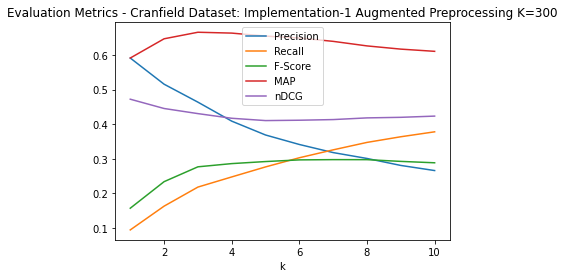

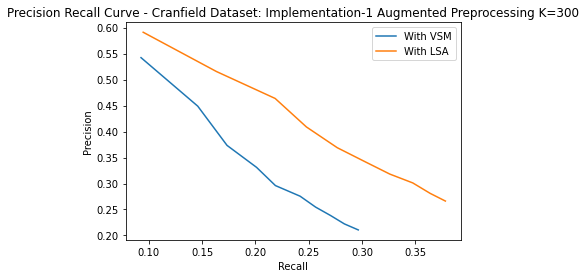

-----------------------------


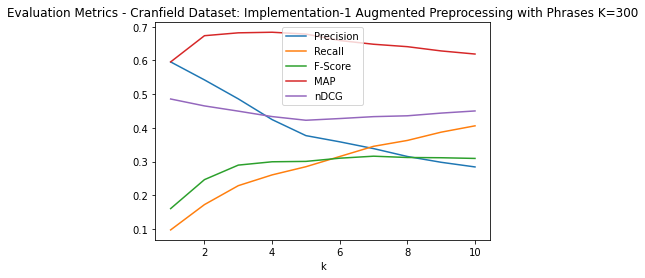

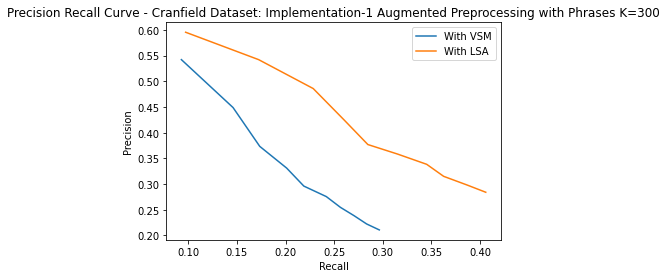

-----------------------------


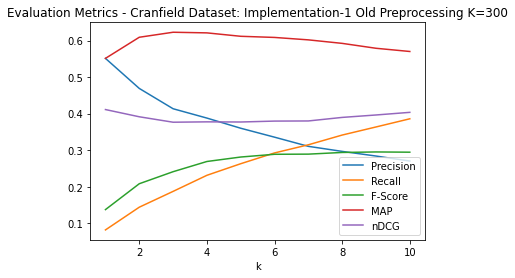

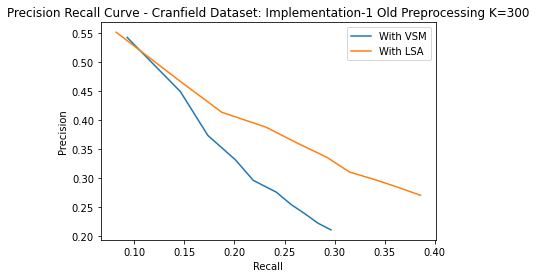

-----------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in double_scalars


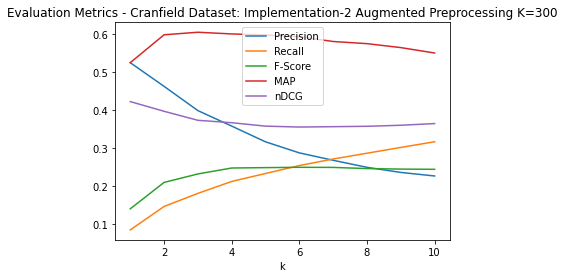

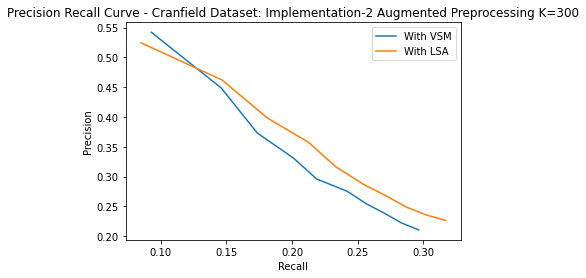

-----------------------------


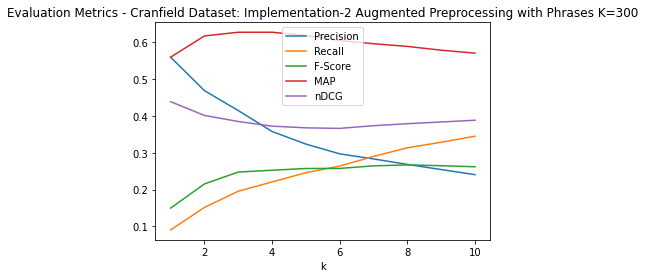

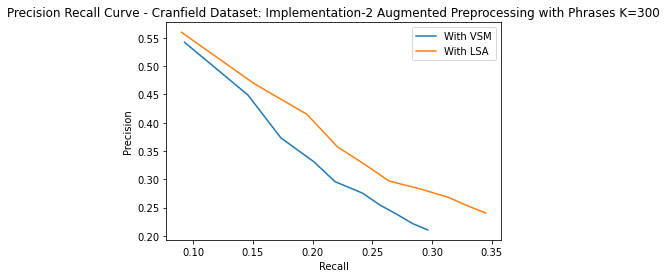

-----------------------------


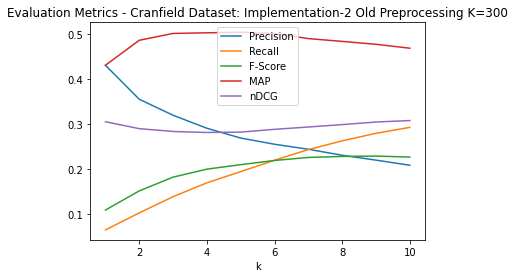

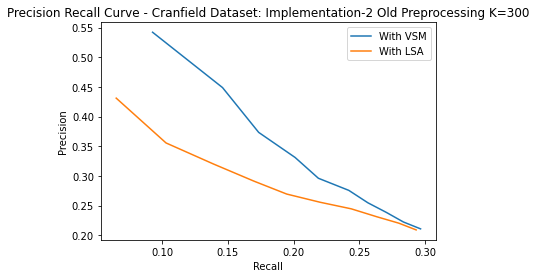

-----------------------------
==================== K is 350 =====================


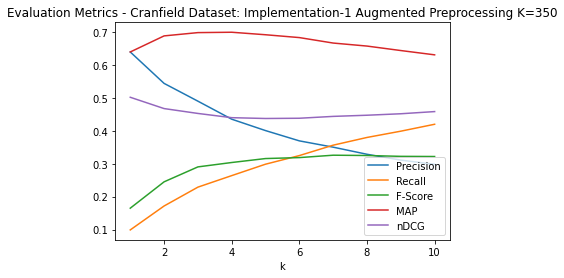

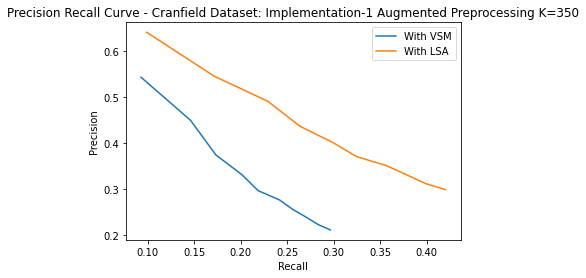

-----------------------------


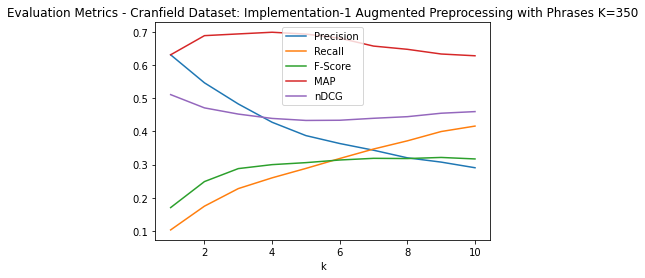

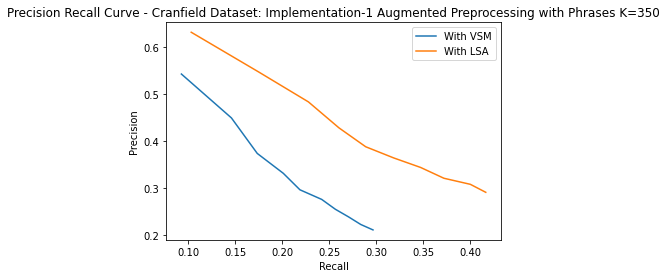

-----------------------------


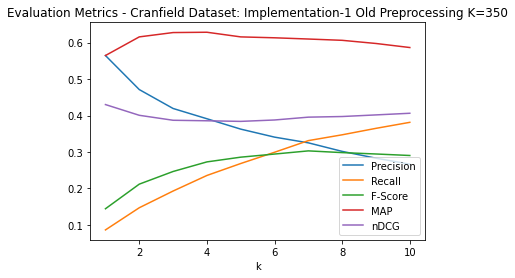

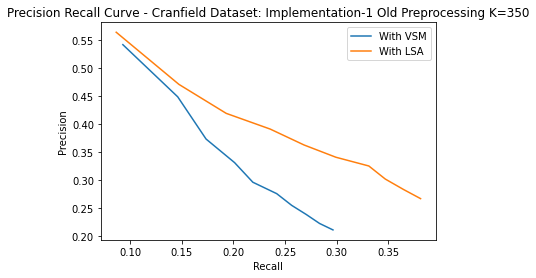

-----------------------------


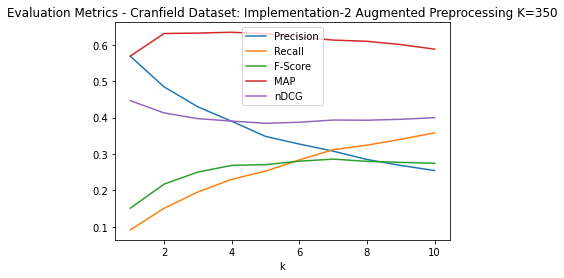

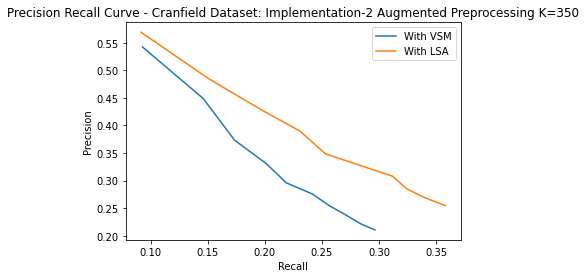

-----------------------------


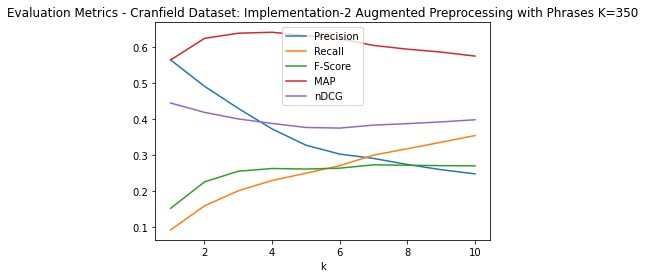

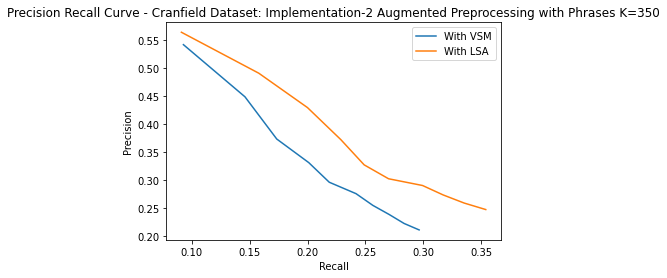

-----------------------------


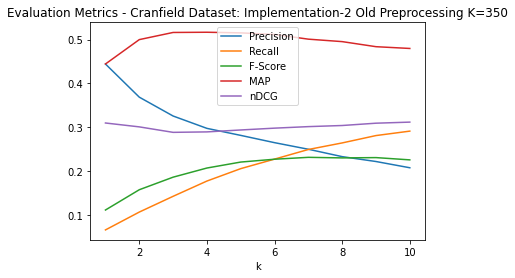

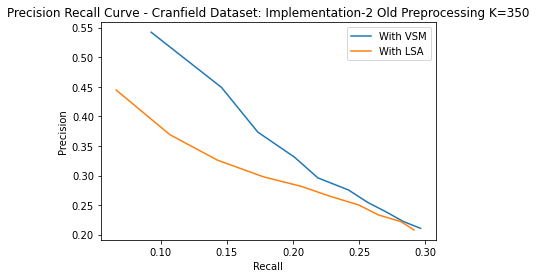

-----------------------------
==================== K is 400 =====================


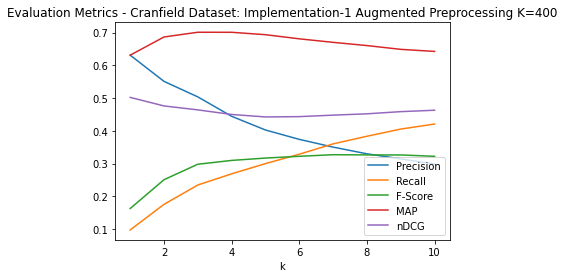

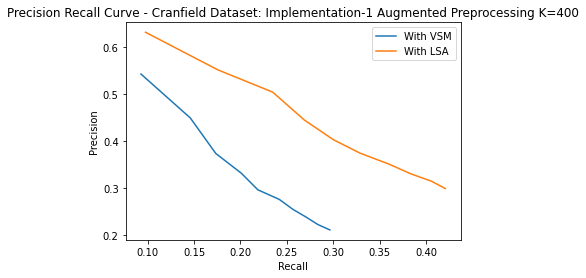

-----------------------------


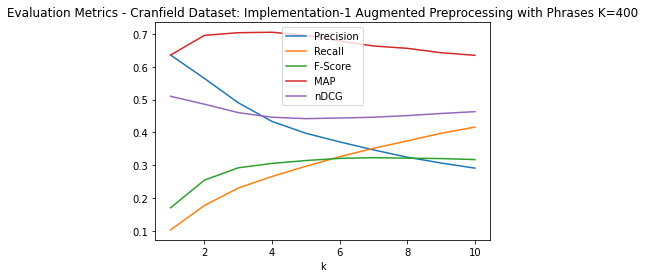

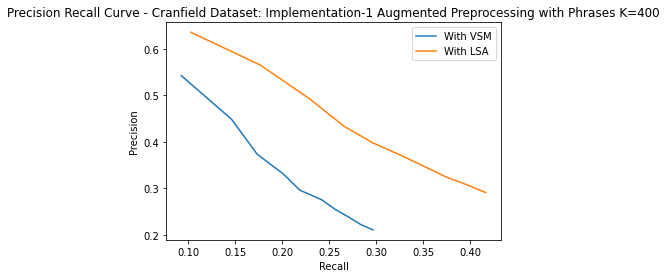

-----------------------------


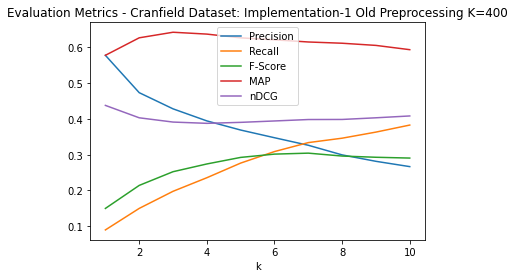

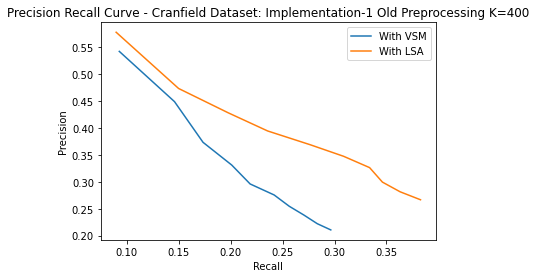

-----------------------------


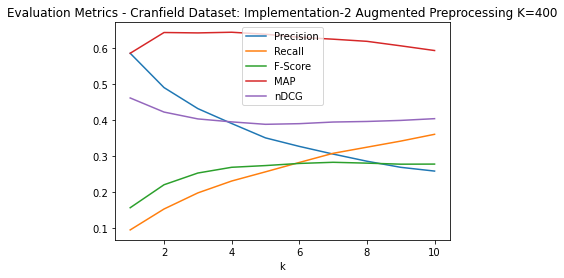

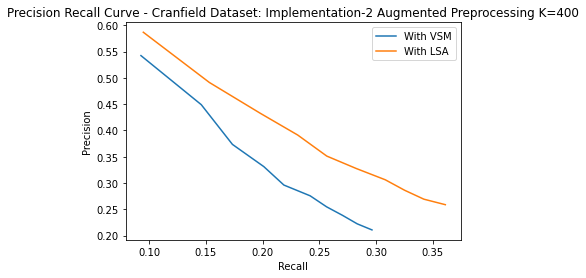

-----------------------------


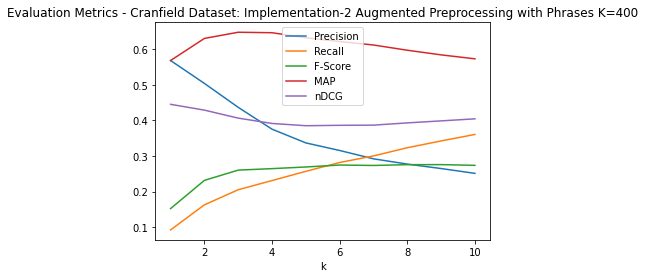

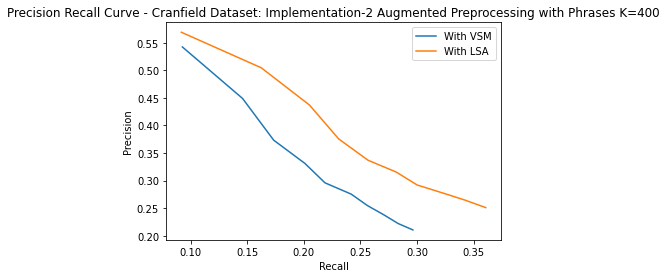

-----------------------------


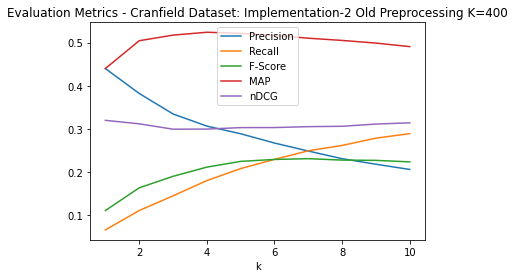

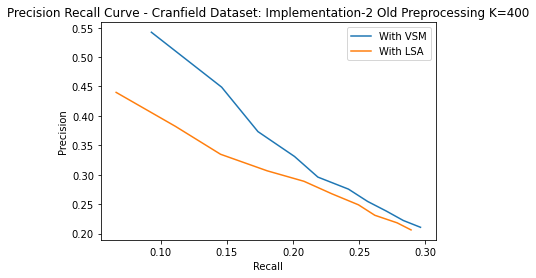

-----------------------------
==================== K is 450 =====================


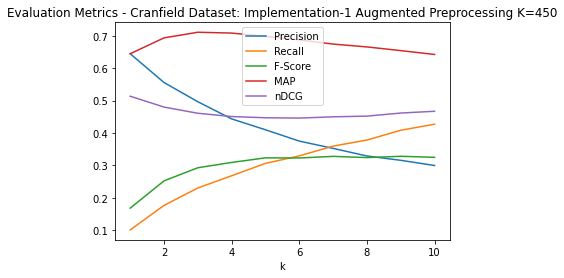

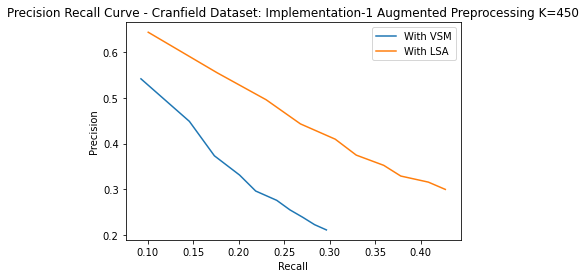

-----------------------------


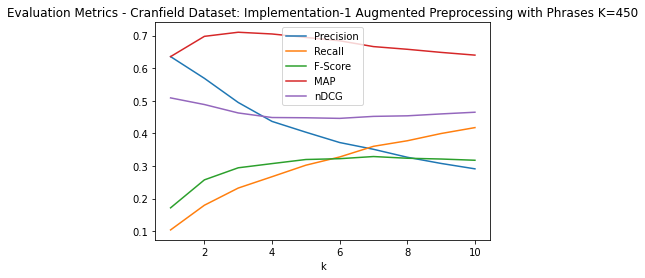

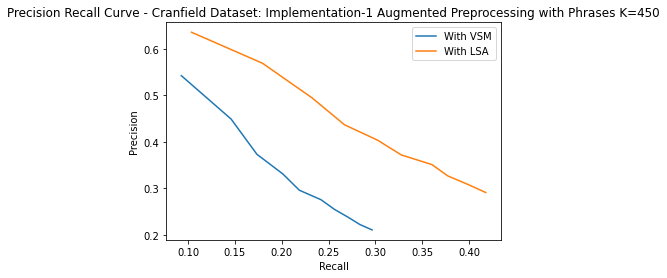

-----------------------------


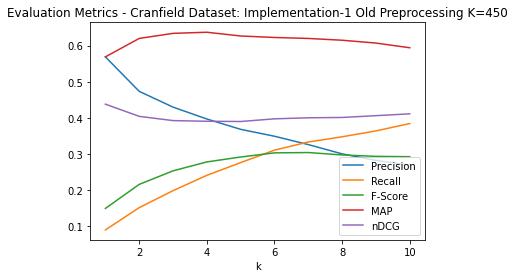

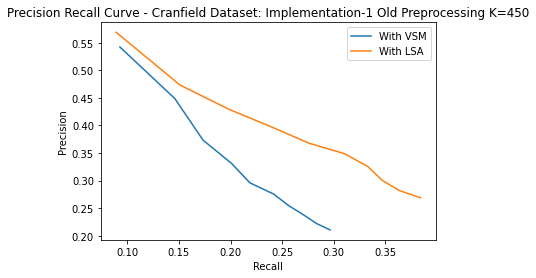

-----------------------------


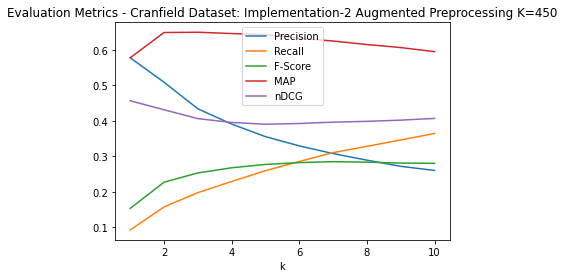

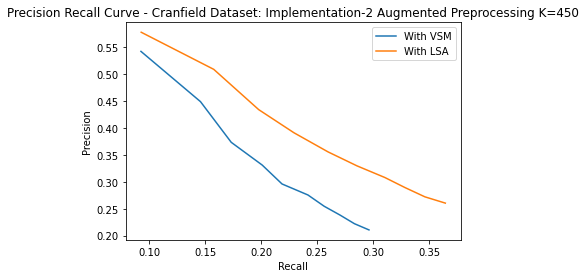

-----------------------------


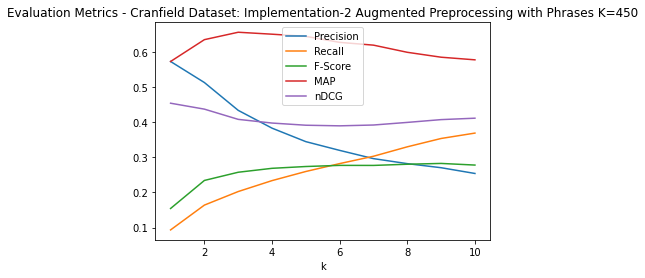

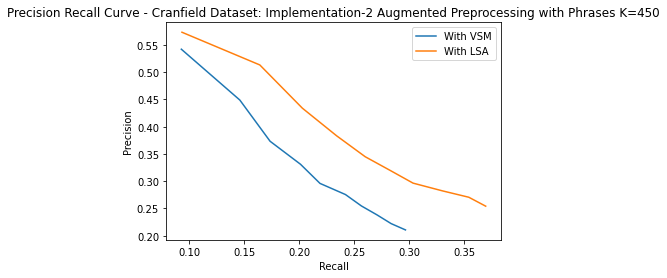

-----------------------------


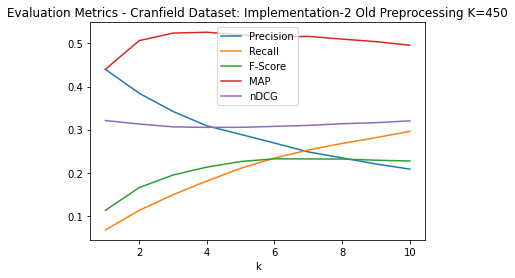

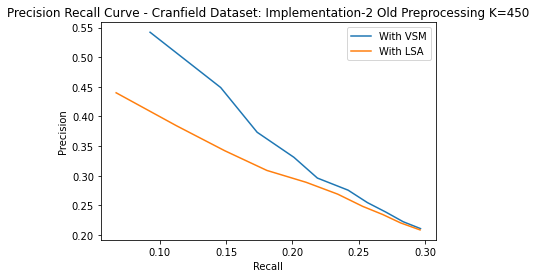

-----------------------------
==================== K is 500 =====================


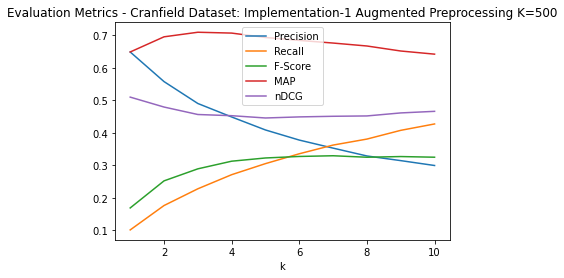

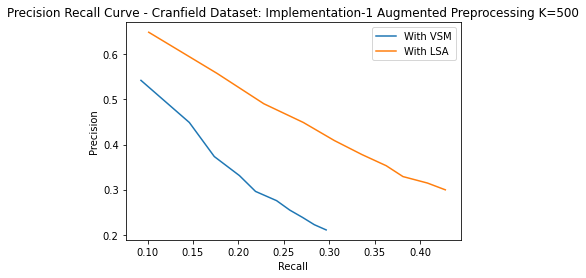

-----------------------------


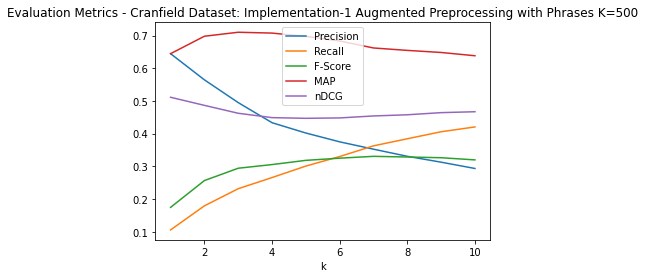

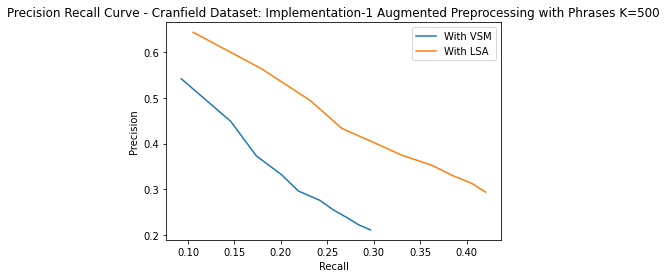

-----------------------------


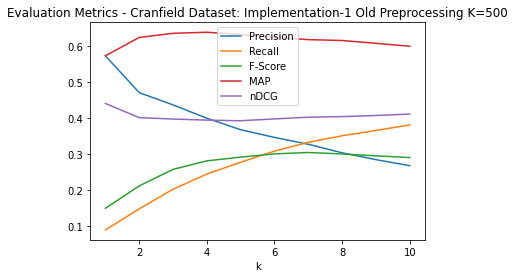

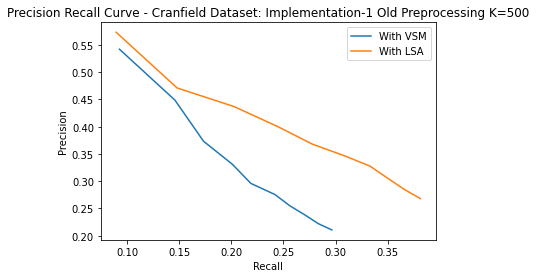

-----------------------------


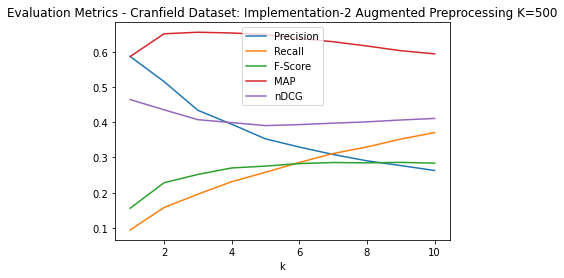

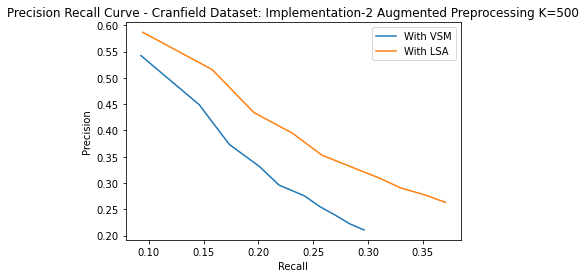

-----------------------------


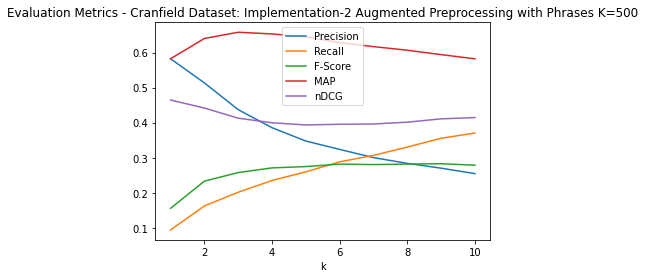

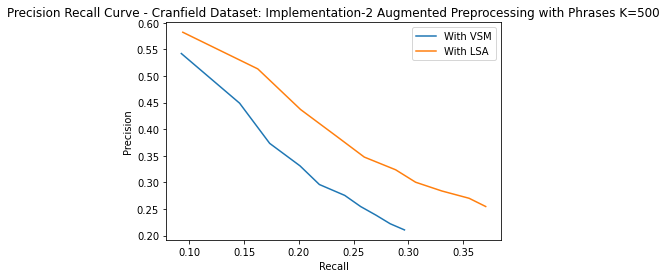

-----------------------------


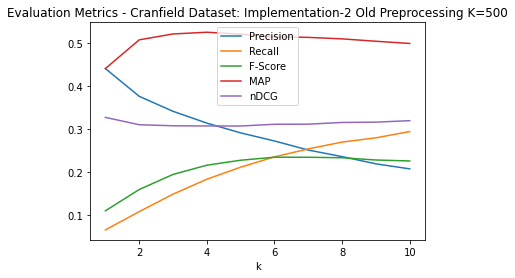

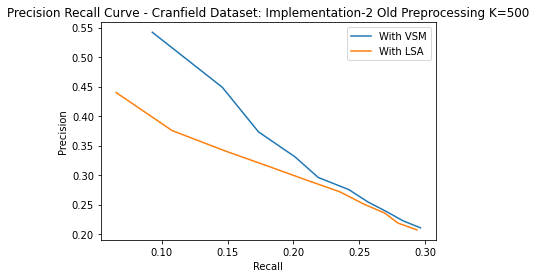

-----------------------------
==================== K is 550 =====================


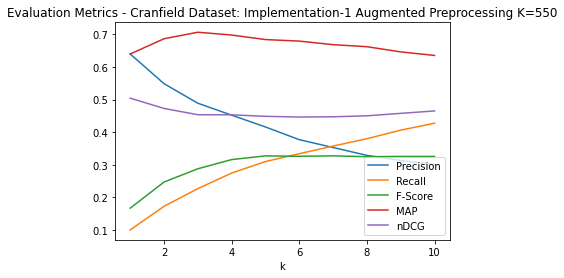

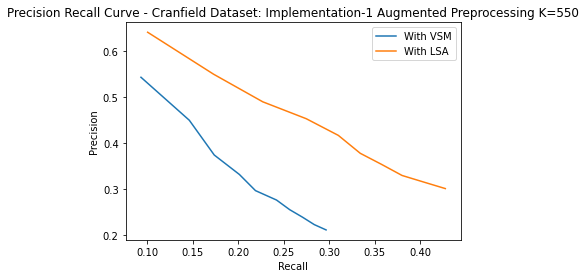

-----------------------------


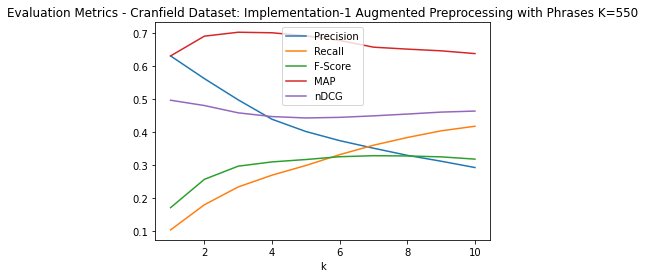

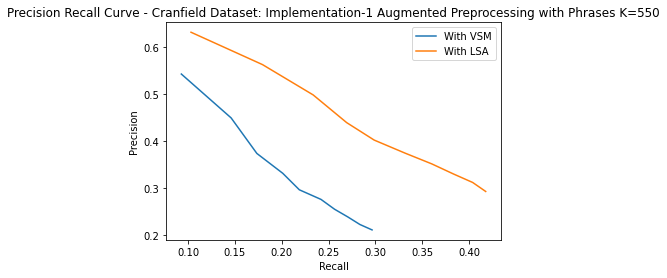

-----------------------------


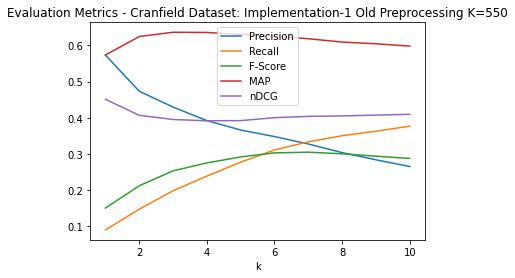

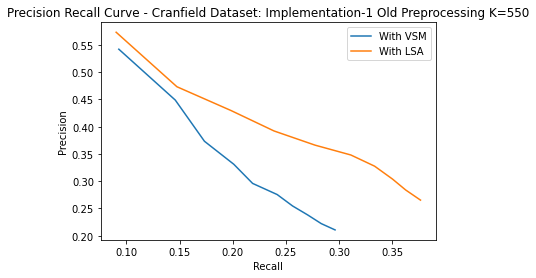

-----------------------------


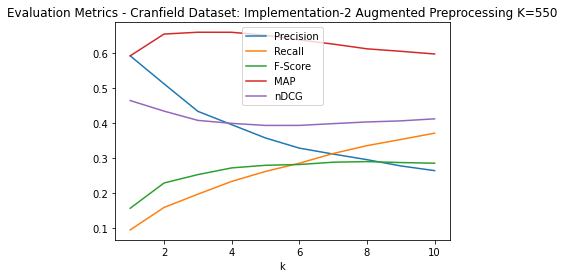

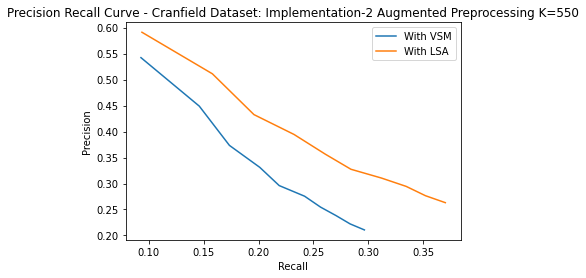

-----------------------------


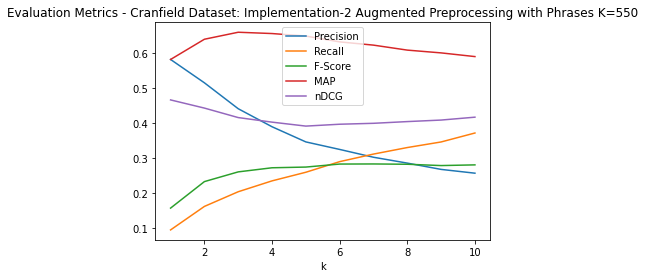

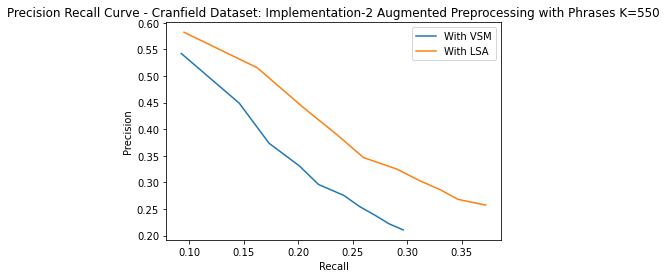

-----------------------------


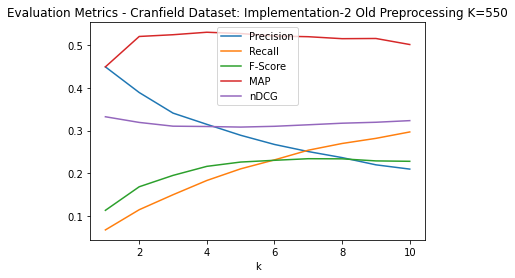

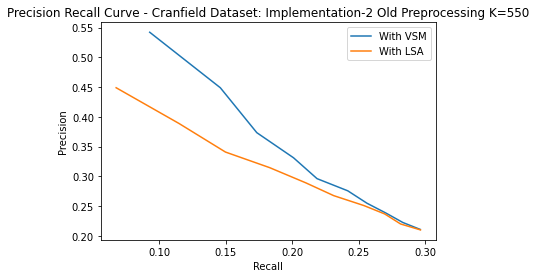

-----------------------------
==================== K is 600 =====================


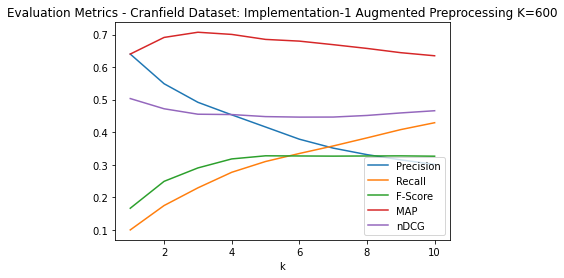

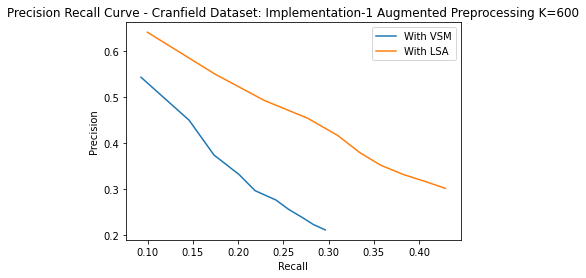

-----------------------------


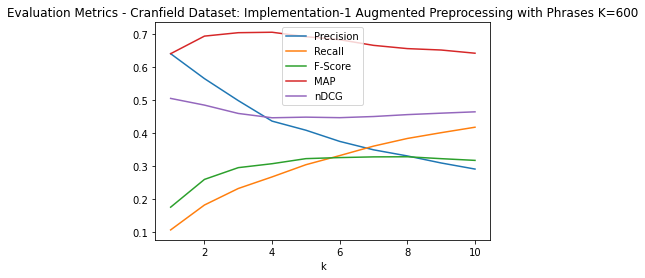

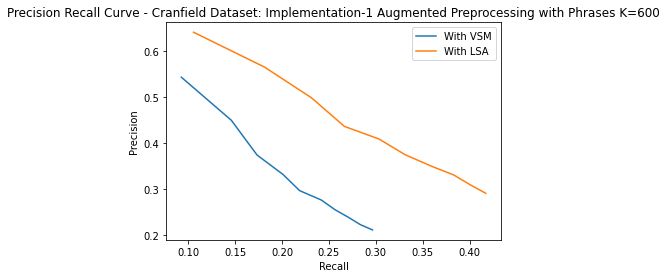

-----------------------------


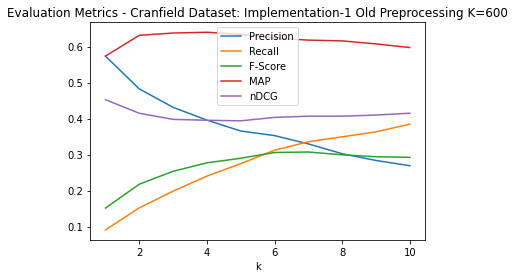

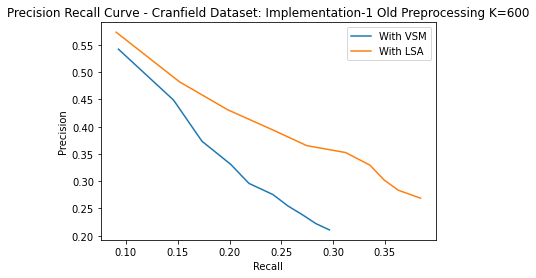

-----------------------------


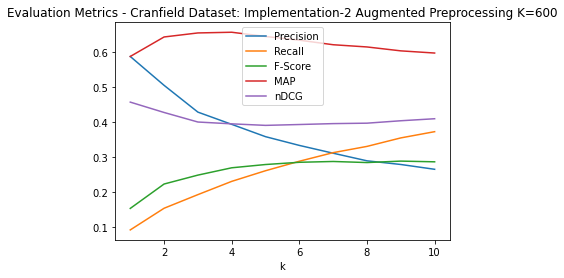

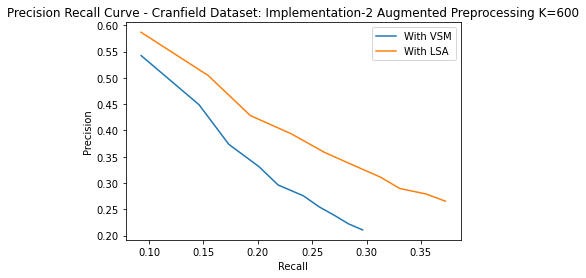

-----------------------------


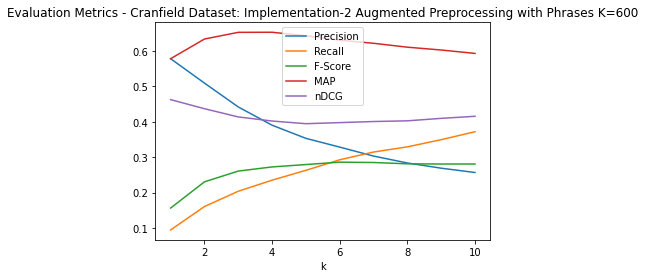

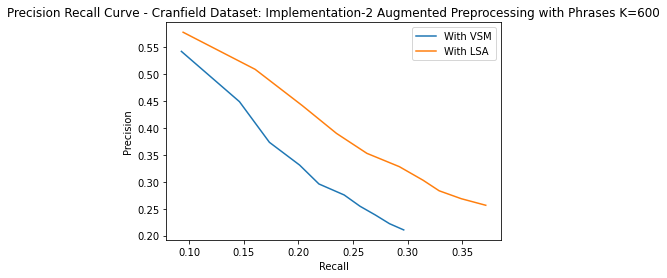

-----------------------------


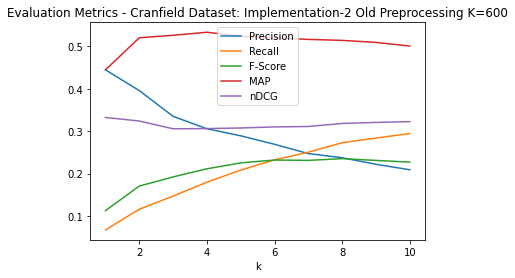

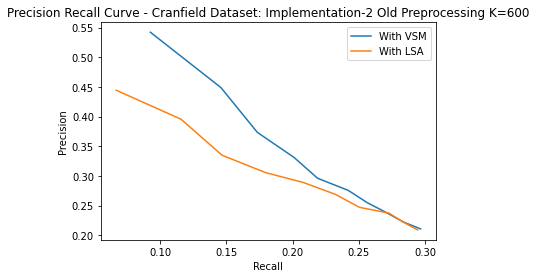

-----------------------------
==================== K is 650 =====================


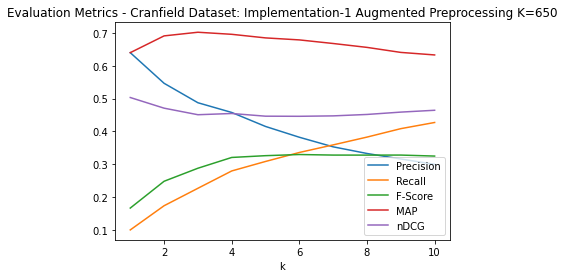

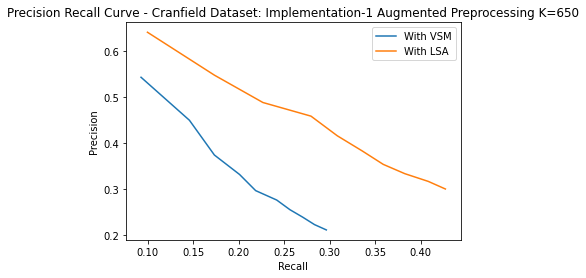

-----------------------------


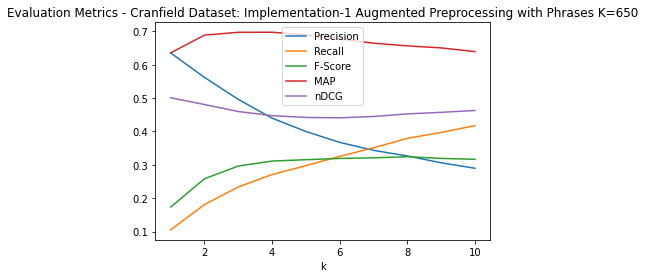

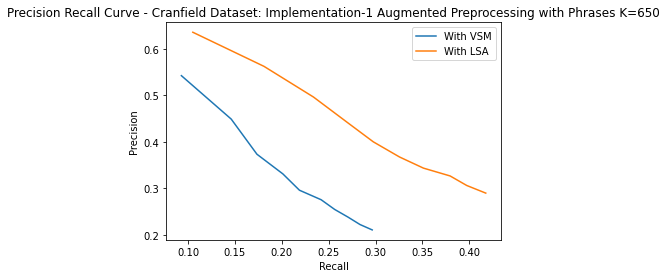

-----------------------------


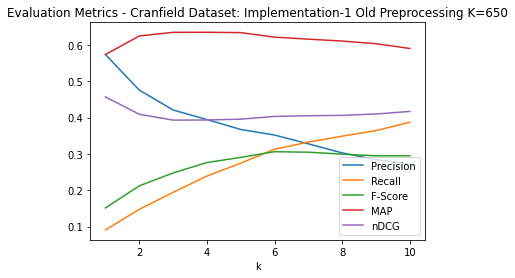

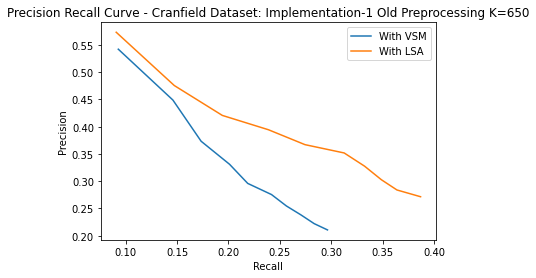

-----------------------------


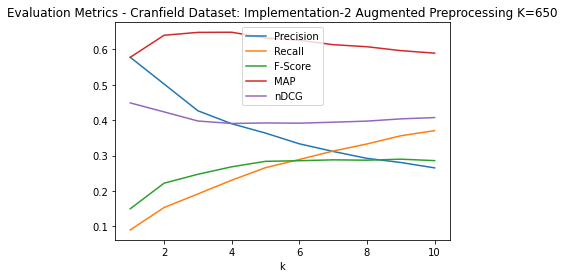

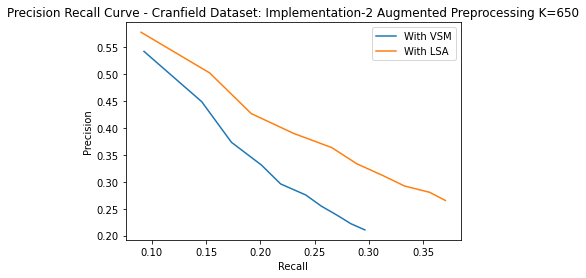

-----------------------------


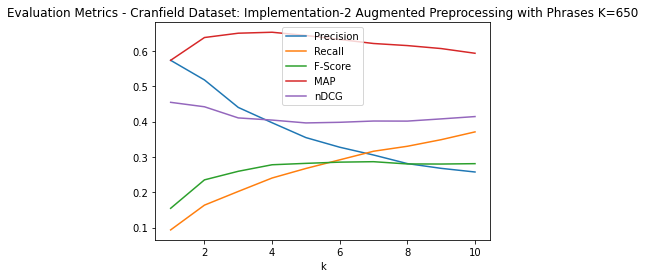

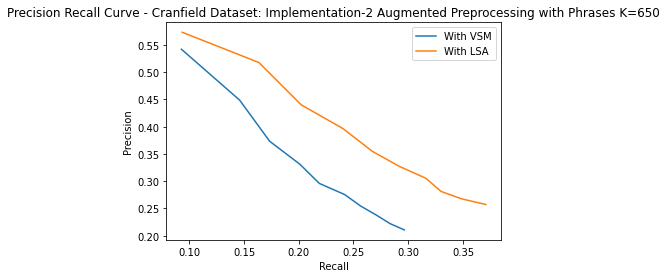

-----------------------------


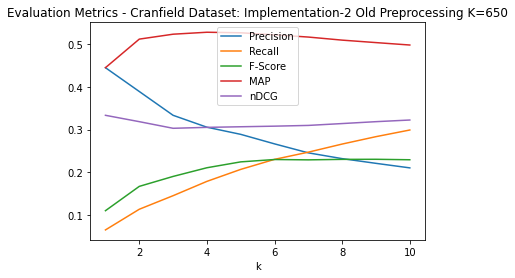

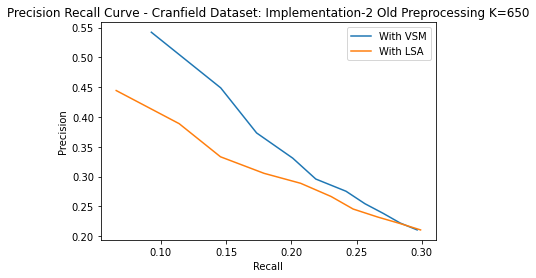

-----------------------------
==================== K is 700 =====================


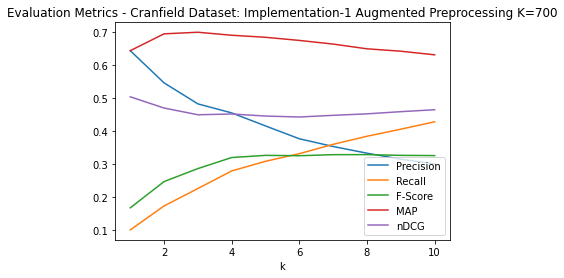

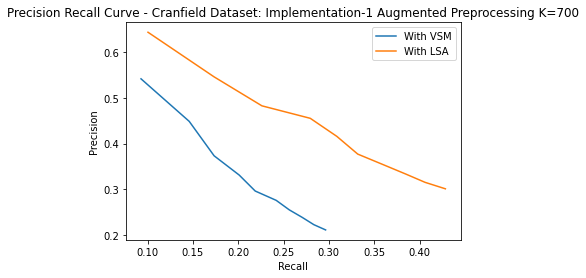

-----------------------------


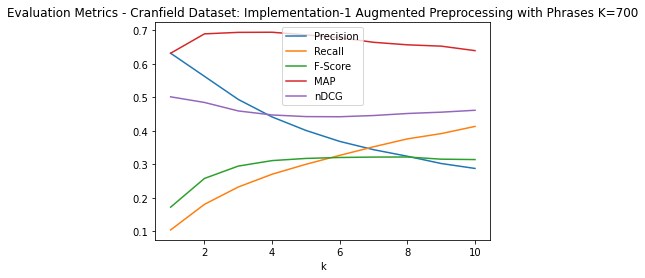

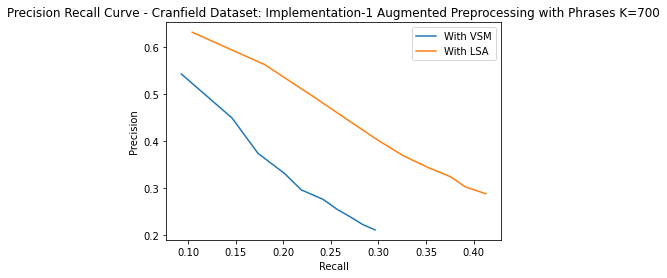

-----------------------------


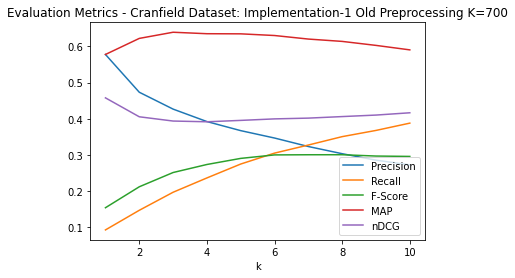

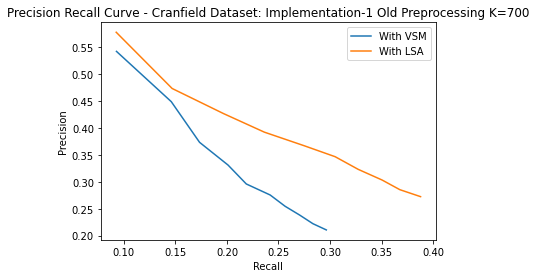

-----------------------------


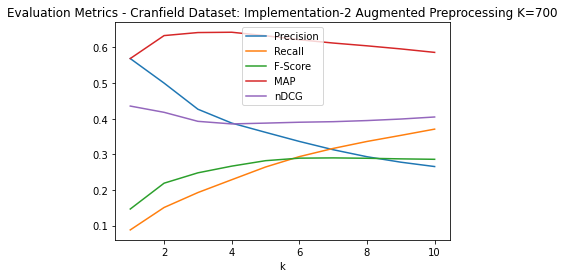

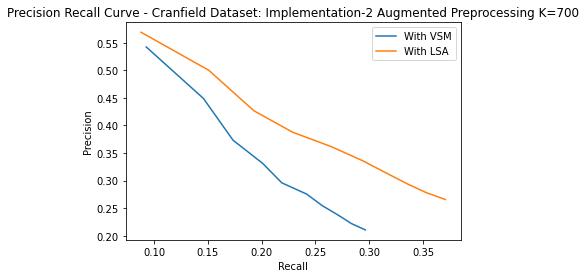

-----------------------------


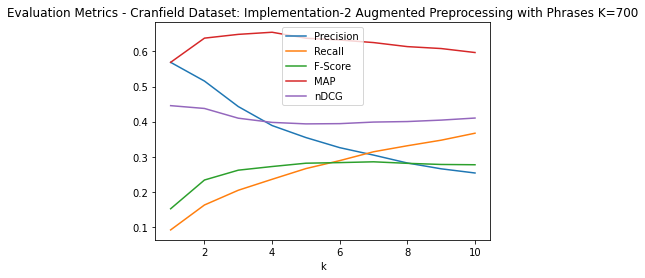

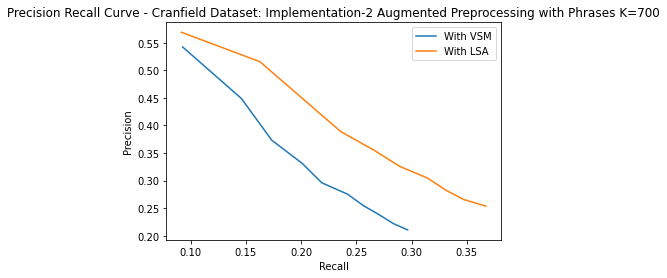

-----------------------------


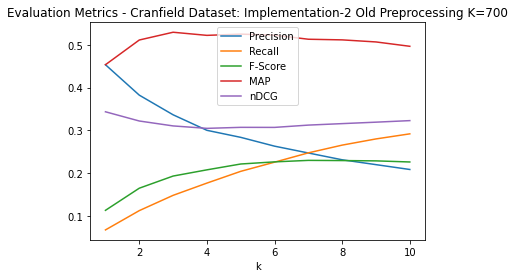

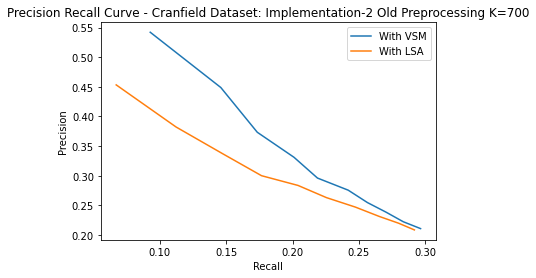

-----------------------------
==================== K is 750 =====================


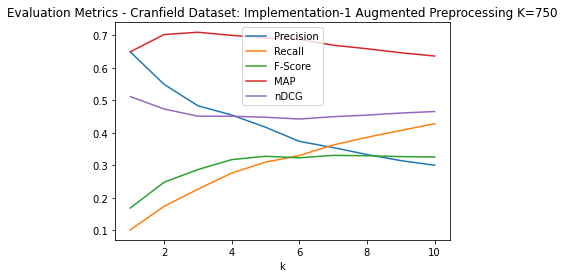

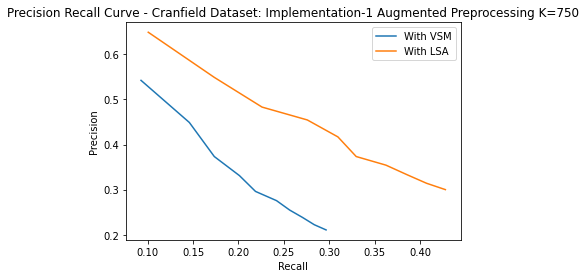

-----------------------------


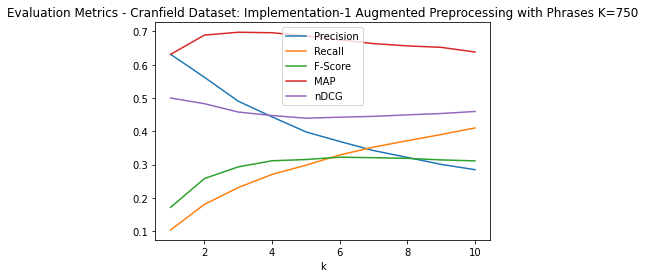

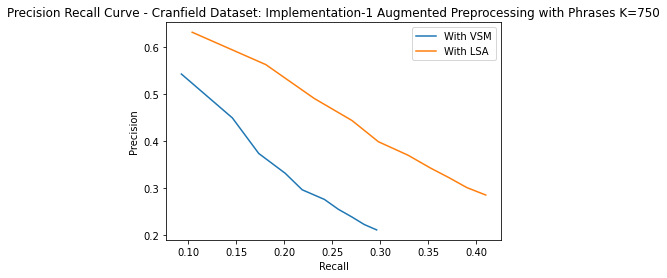

-----------------------------


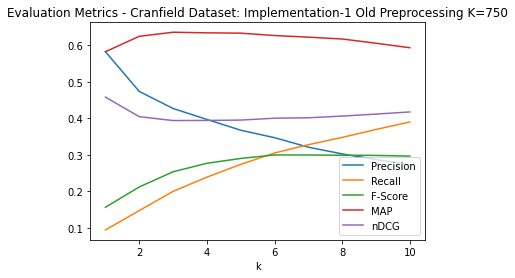

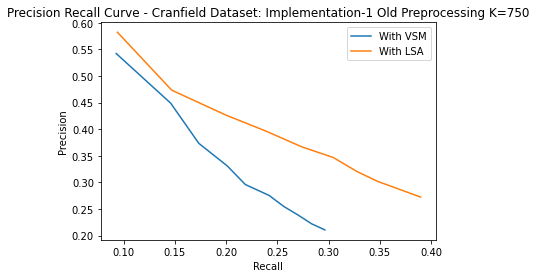

-----------------------------


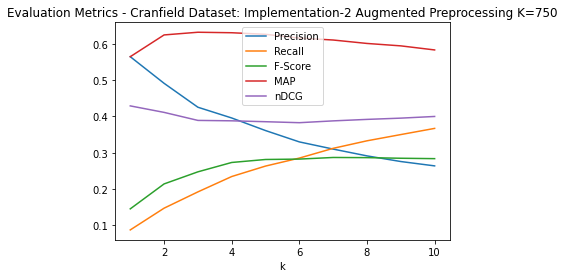

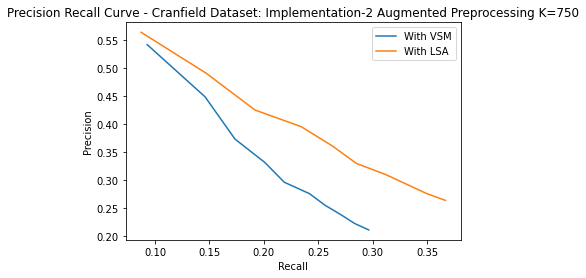

-----------------------------


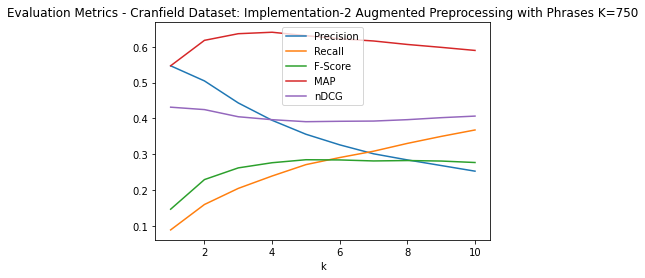

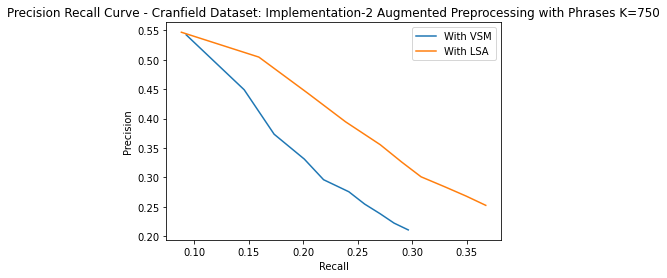

-----------------------------


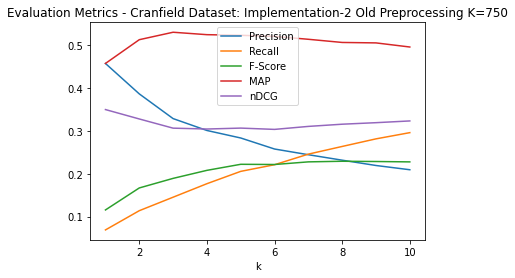

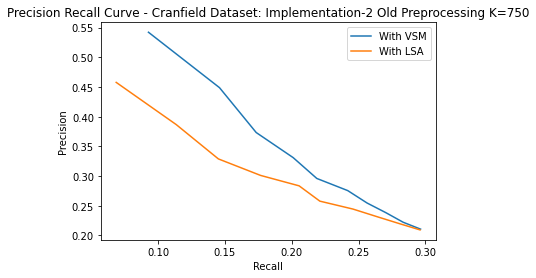

-----------------------------
==================== K is 800 =====================


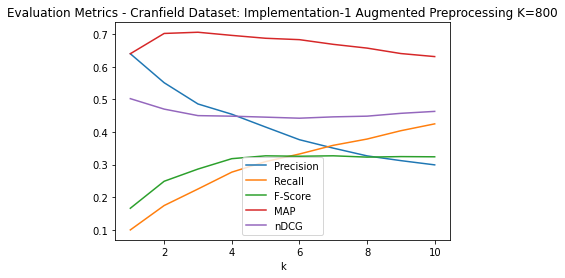

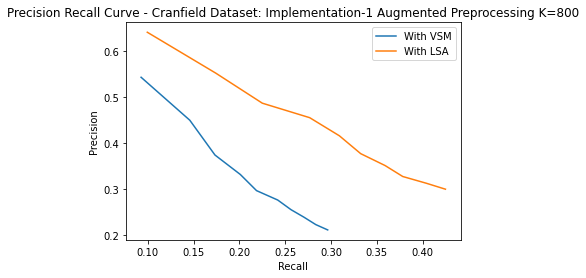

-----------------------------


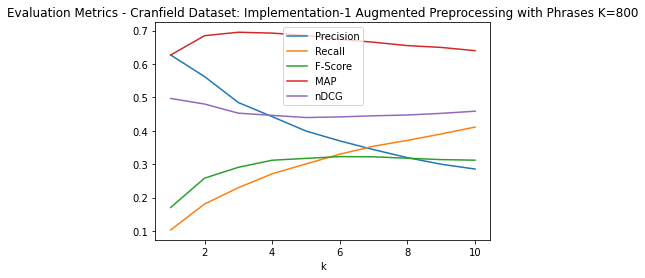

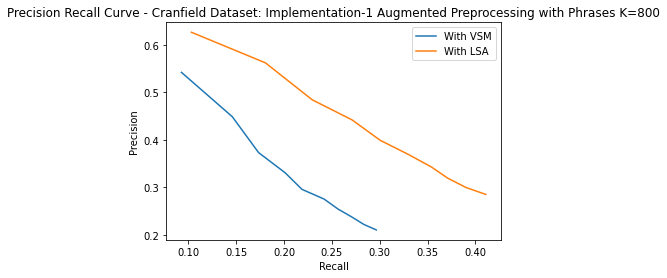

-----------------------------


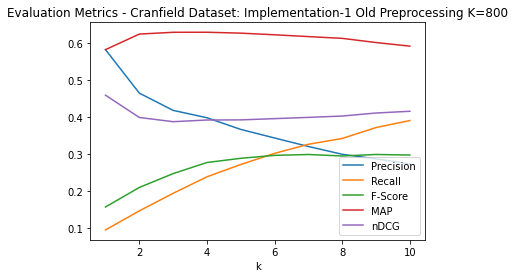

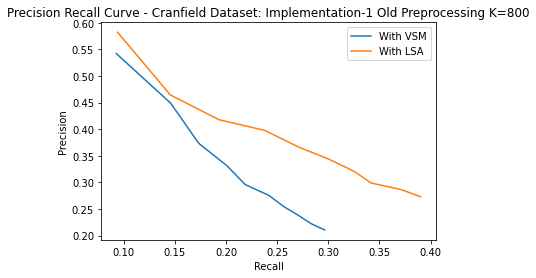

-----------------------------


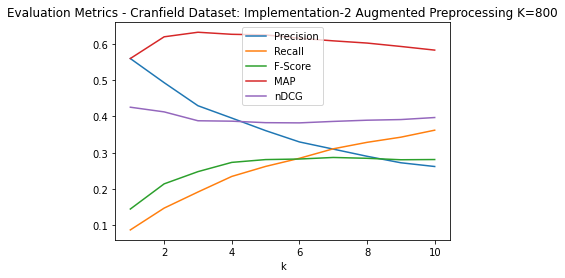

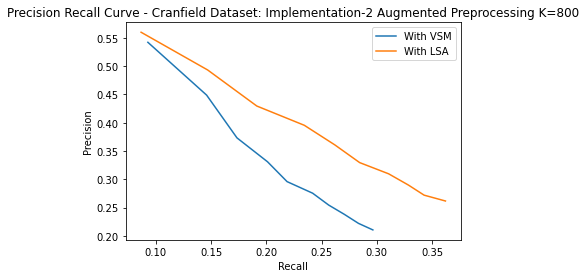

-----------------------------


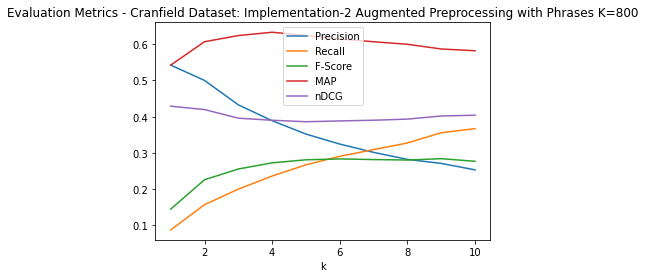

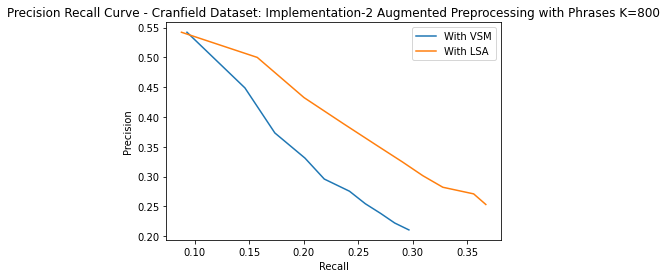

-----------------------------


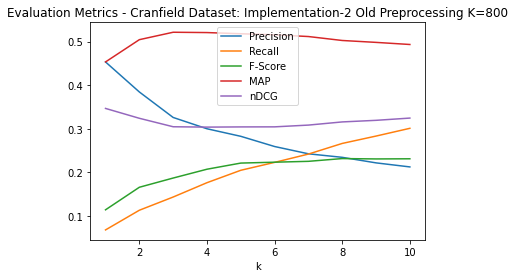

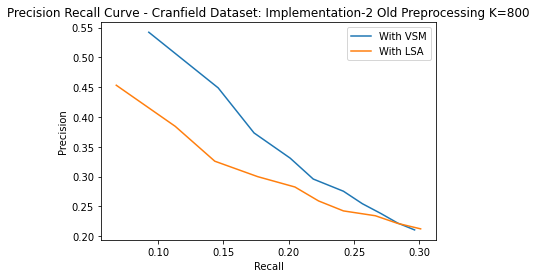

-----------------------------
==================== K is 850 =====================


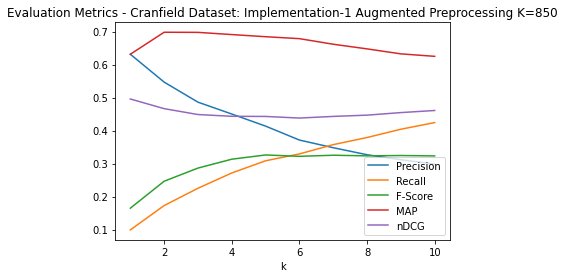

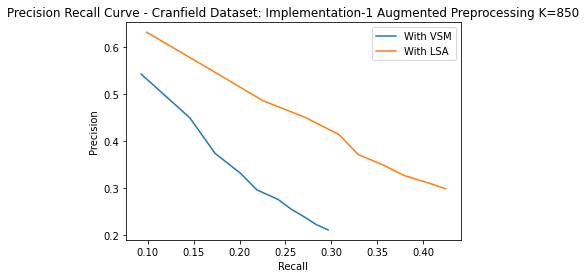

-----------------------------


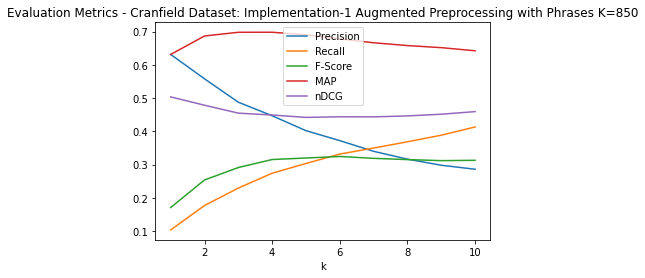

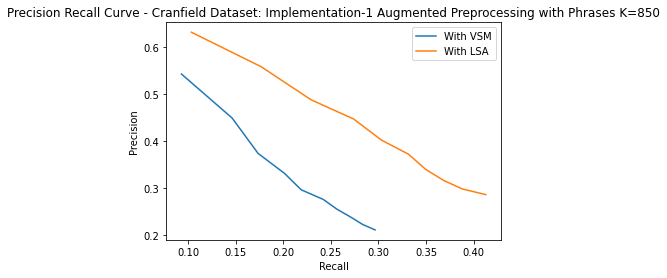

-----------------------------


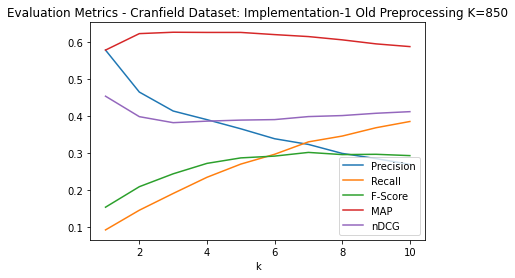

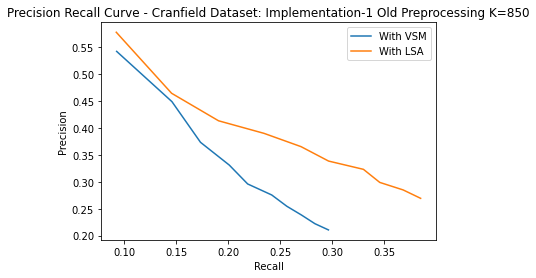

-----------------------------


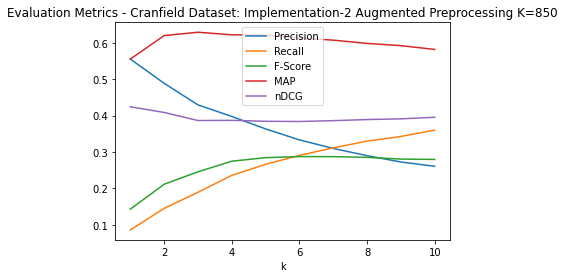

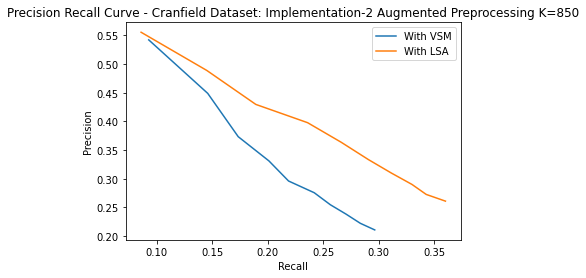

-----------------------------


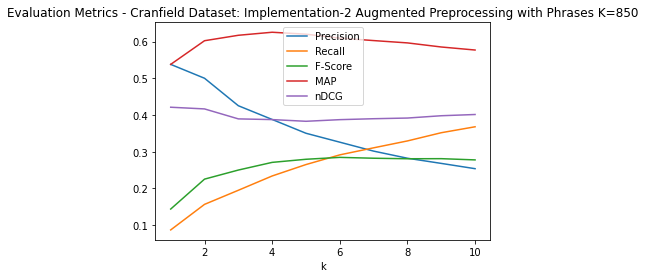

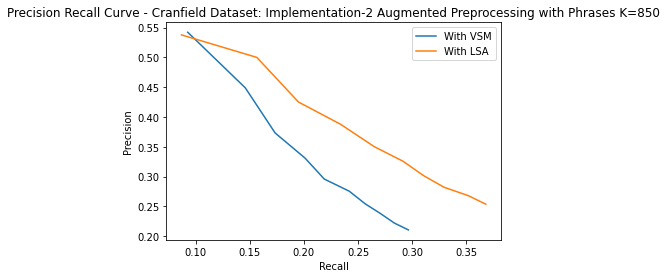

-----------------------------


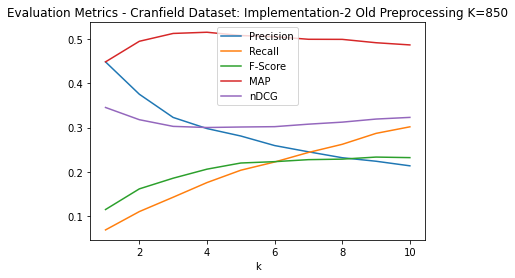

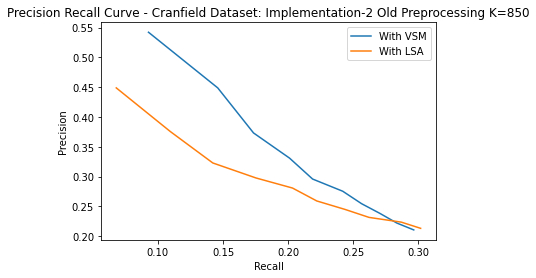

-----------------------------
==================== K is 900 =====================


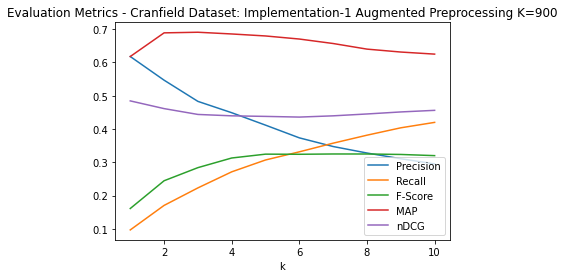

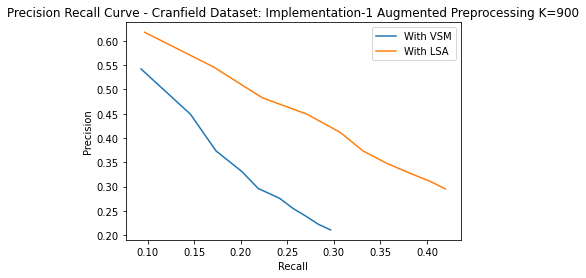

-----------------------------


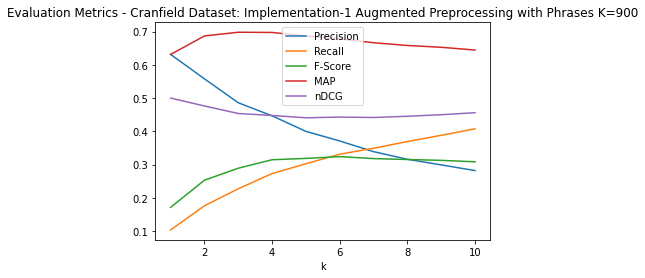

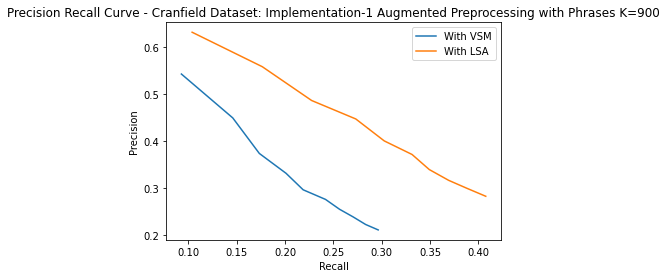

-----------------------------


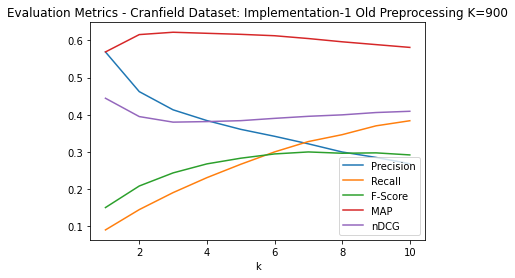

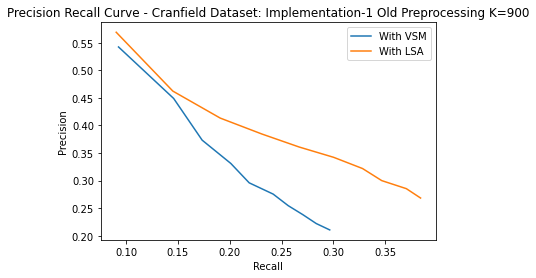

-----------------------------


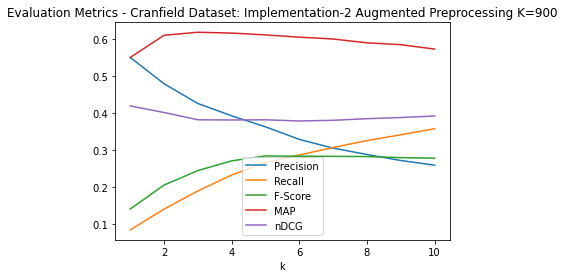

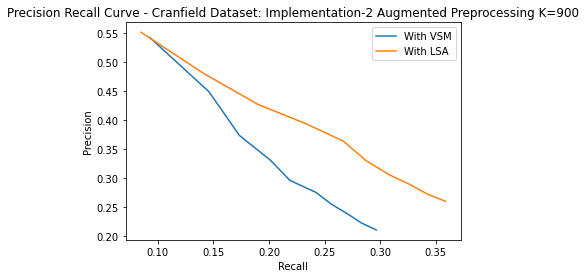

-----------------------------


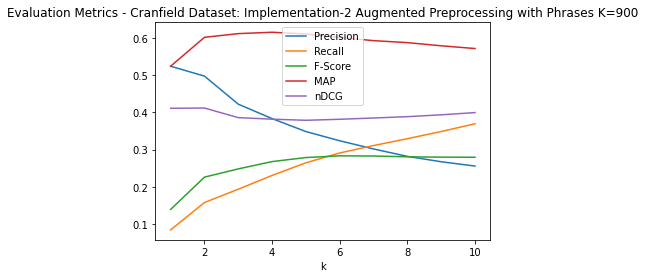

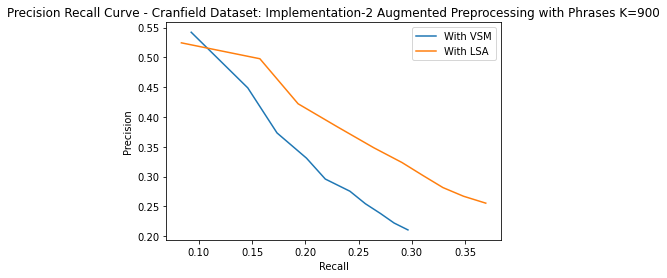

-----------------------------


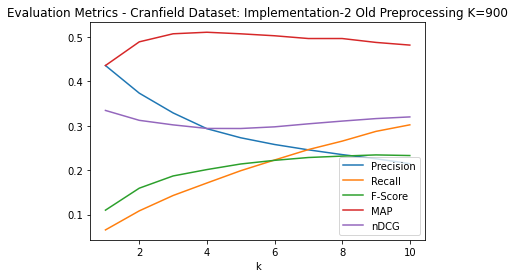

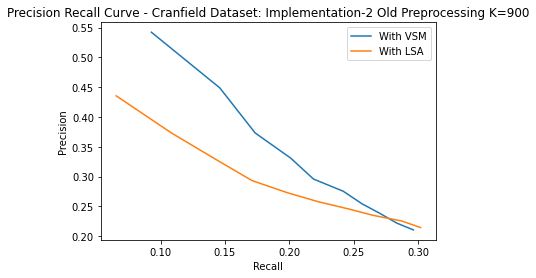

-----------------------------
==================== K is 950 =====================


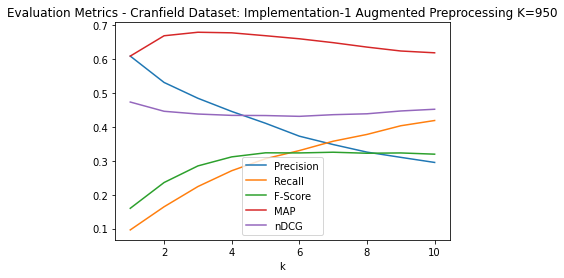

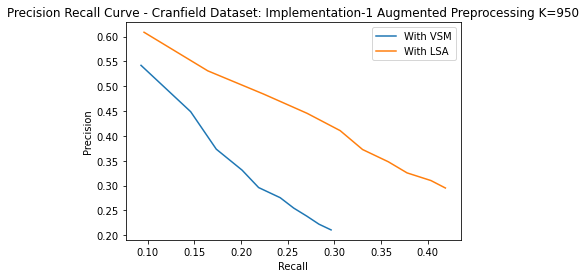

-----------------------------


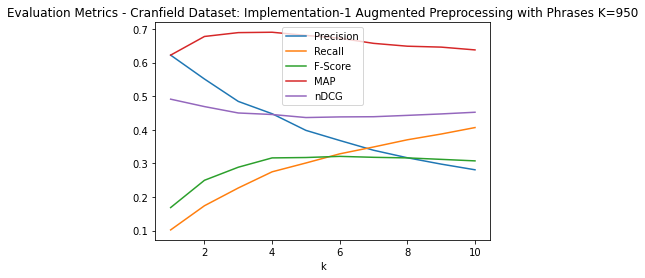

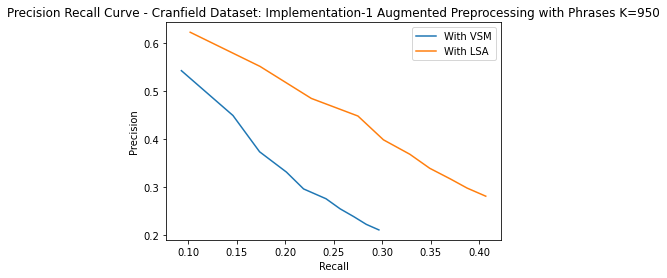

-----------------------------


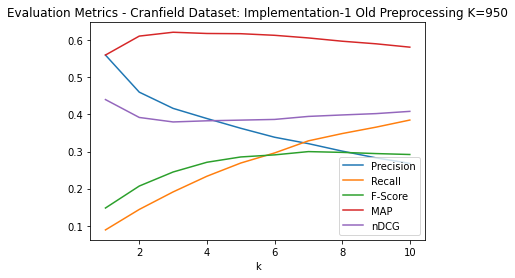

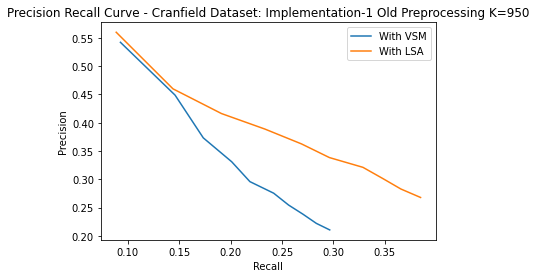

-----------------------------


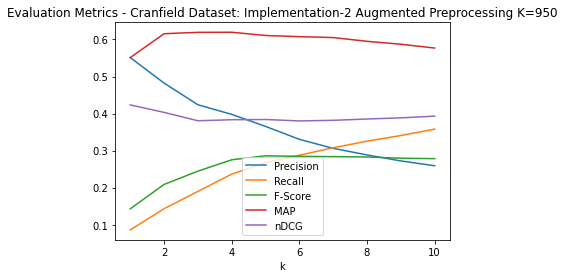

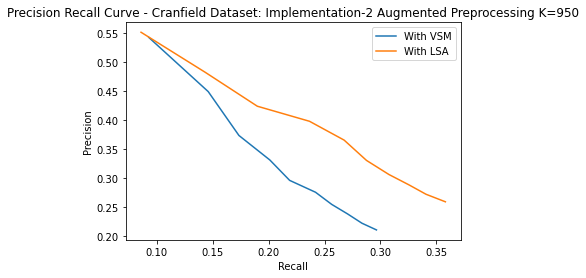

-----------------------------


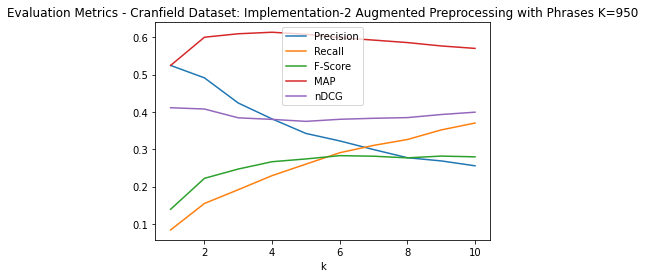

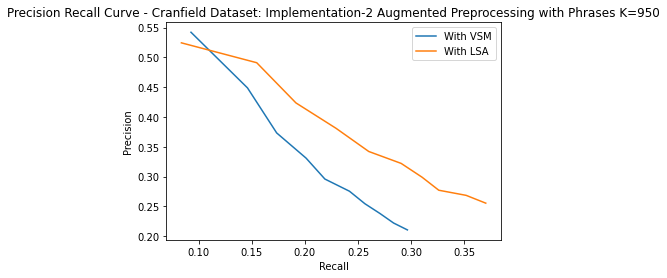

-----------------------------


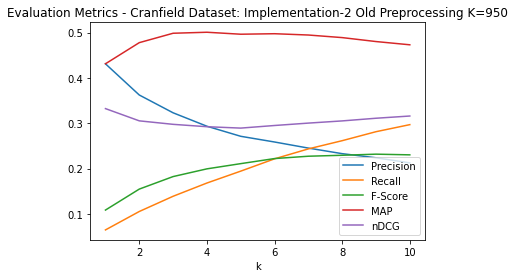

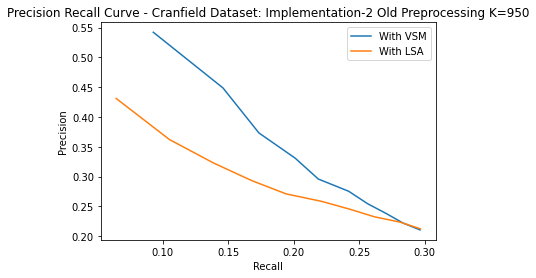

-----------------------------
The best K is  450
The Maximum MAP is  0.698061728395061
Best implementation Implementation-1
Best doc Augmented Preprocessing


In [ ]:
K = (np.arange(300, 1000, 100))
map10_list = []
ndcg10_list = []
k_dic = {0:[[],[]], 1:[[],[]], 2:[[],[]], 3:[[],[]], 4:[[],[]], 5:[[],[]]}
# 0,1,2 implementation 1
# 3,4,5 implementation 2
R_list = [InformationRetrieval_1()]*3 + [InformationRetrieval_2()]*3 
doc_list = [cleanDocs, cleanDocs_bigram, reducedDocs]*2
implementation_string = ["Implementation-1"]*3 + ["Implementation-2"]*3
doc_string = ["Augmented Preprocessing", "Augmented Preprocessing with Phrases", "Old Preprocessing"]*2
max_map = 0
query_list = [cleanQueries, cleanQueries_bigram, reducedQueries]*2
for k in K:
  print("==================== K is {} =====================".format(k))
  for i in range(len(R_list)):
    lsa_call(doc_list[i], doc_ids, query_list[i], R_list[i], k)
    title = "{} {} K={}".format(implementation_string[i], doc_string[i],k)
    MAPs, nDCGs = get_plot(R_list[i].doc_IDs_ordered, title = title, show_result=True)
    k_dic[i][0].append(MAPs[-1])
    k_dic[i][1].append(nDCGs[-1])
    map = MAPs[4] #IT HAS BEEN OBSERVED THAT THE HIGHEST MAP USUALLY OCCURS AT k=3 OR 4. HENCE, MAP@4 IS COMPARED FOR ALL
    if map>max_map:
      max_map = map
      best_implementation = implementation_string[i]
      best_doc = doc_string[i]
      best_K = k
    print("-----------------------------")
print("The best K is ",best_K)
print("The Maximum MAP is ", max_map)
print("Best implementation", best_implementation)
print("Best doc", best_doc)


==================== K is 300 =====================


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in double_scalars


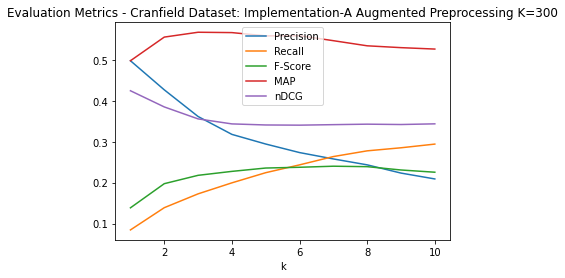

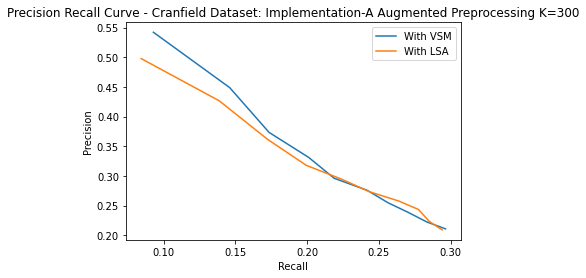

-----------------------------


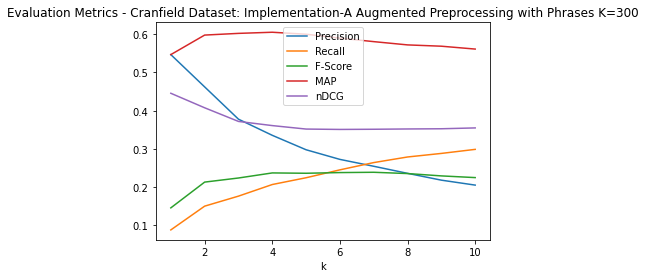

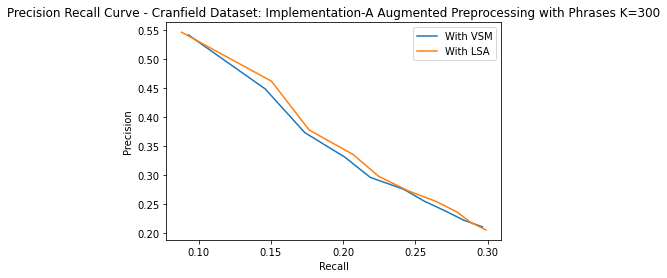

-----------------------------


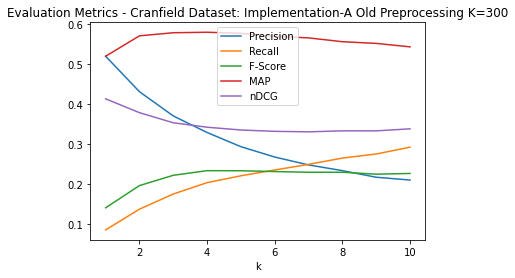

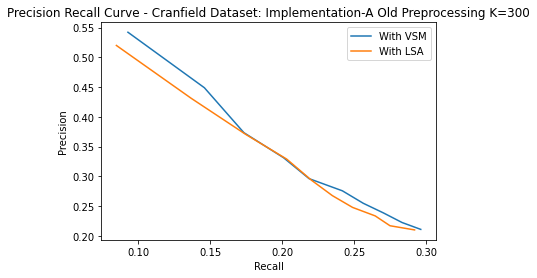

-----------------------------
==================== K is 400 =====================


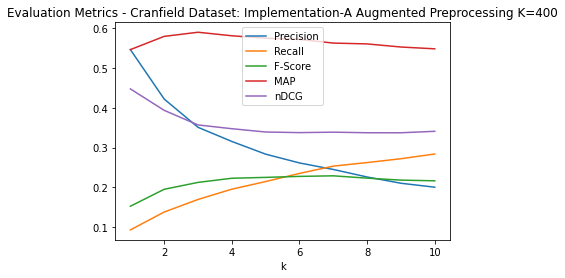

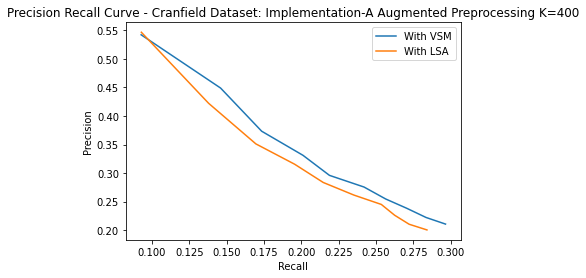

-----------------------------


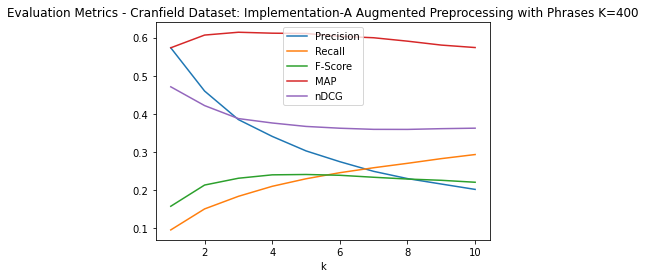

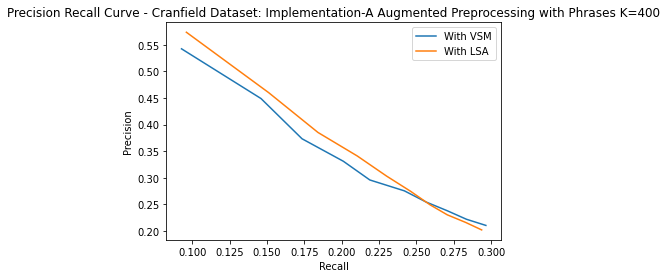

-----------------------------


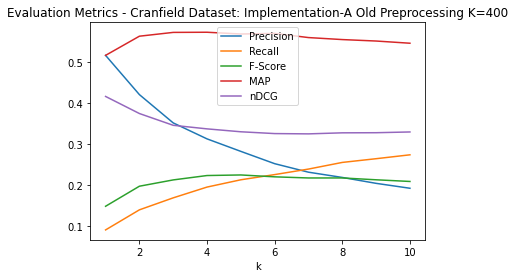

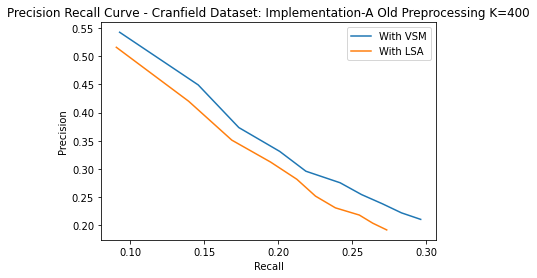

-----------------------------
==================== K is 500 =====================


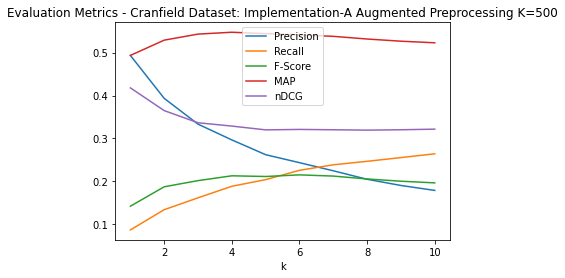

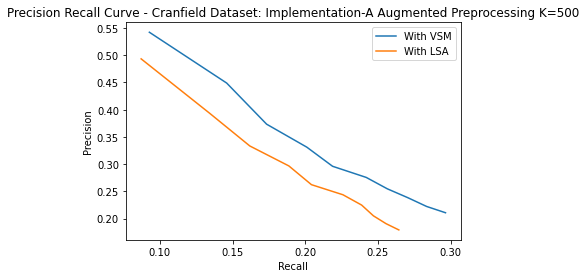

-----------------------------


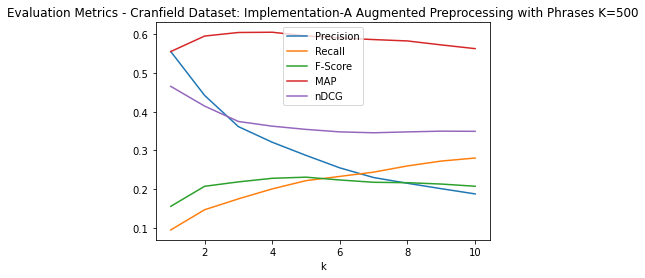

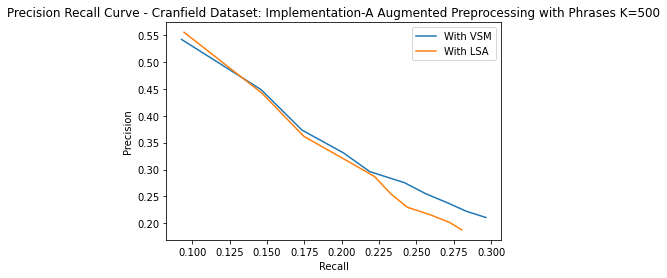

-----------------------------


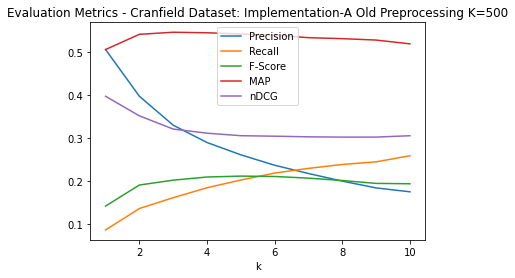

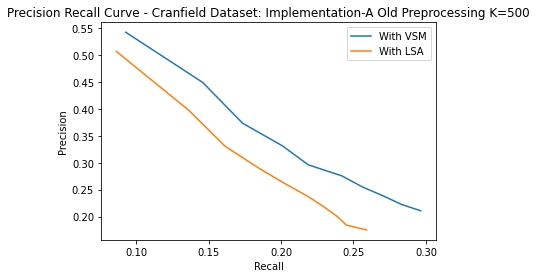

-----------------------------
==================== K is 600 =====================


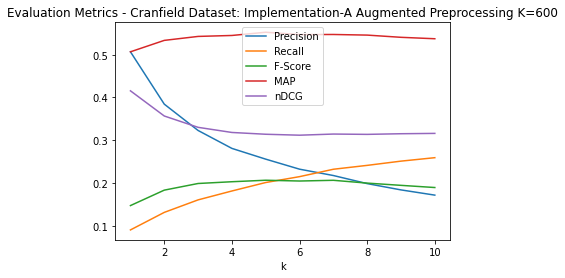

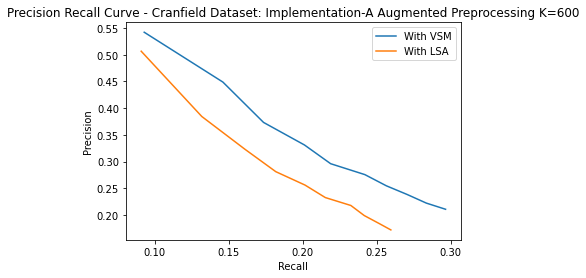

-----------------------------


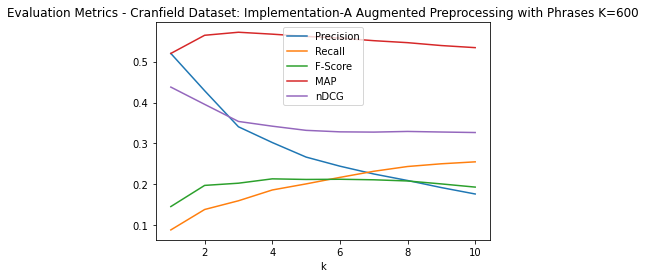

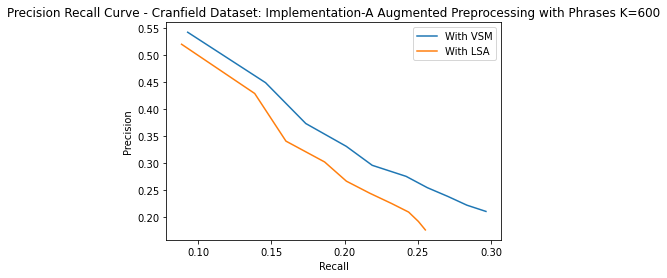

-----------------------------


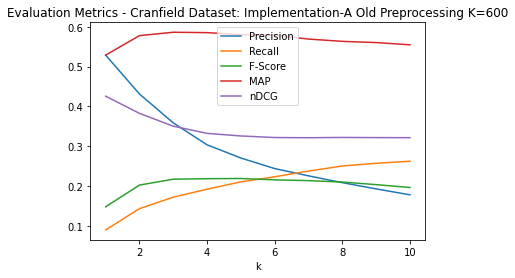

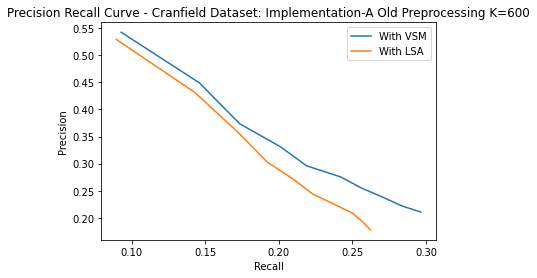

-----------------------------
==================== K is 700 =====================


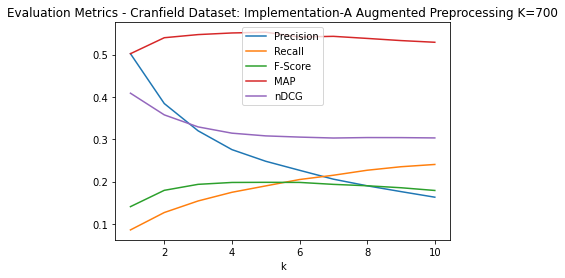

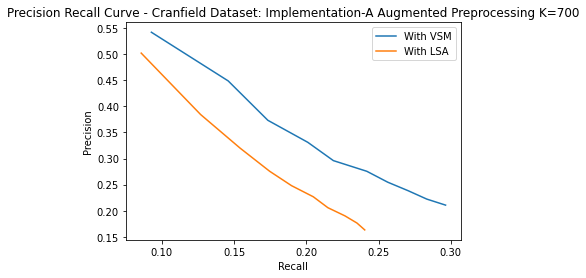

-----------------------------


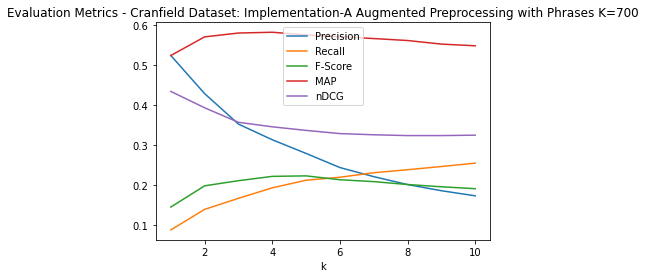

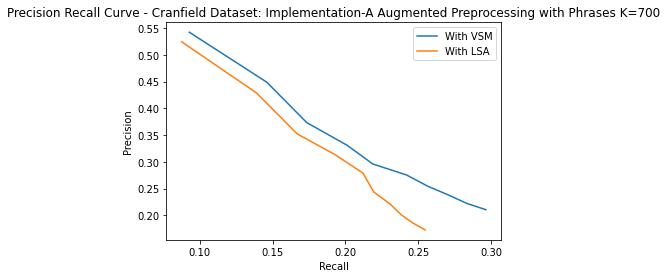

-----------------------------


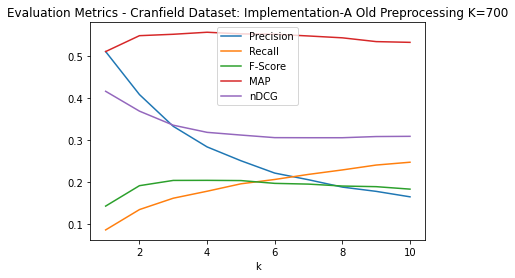

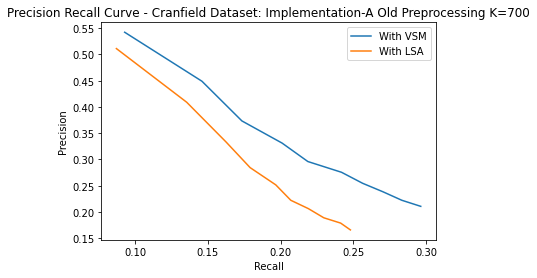

-----------------------------
==================== K is 800 =====================


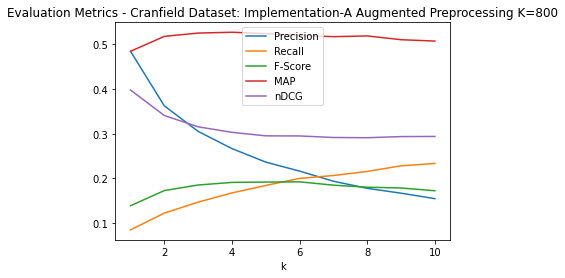

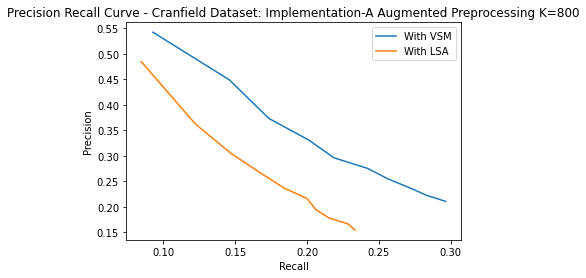

-----------------------------


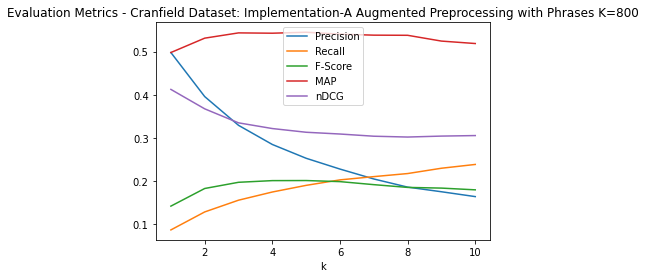

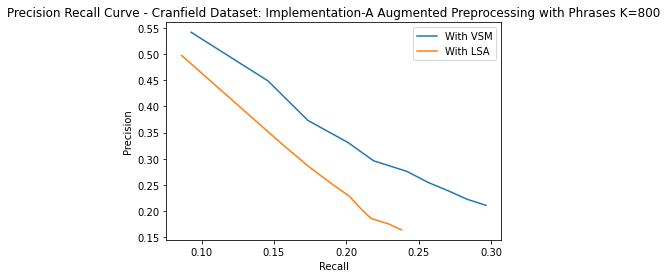

-----------------------------


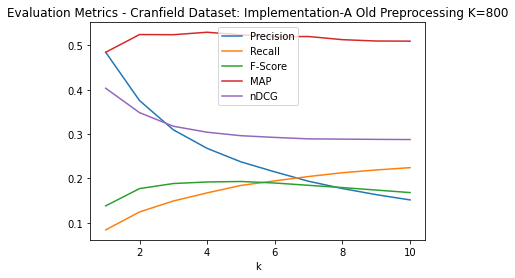

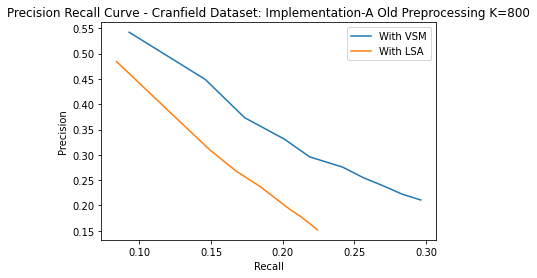

-----------------------------
==================== K is 900 =====================


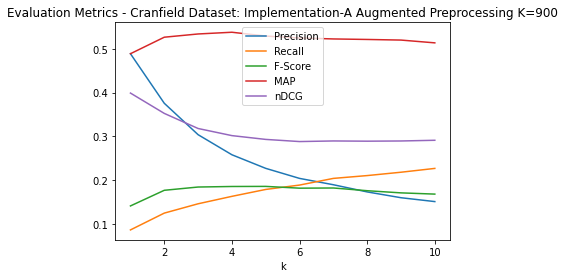

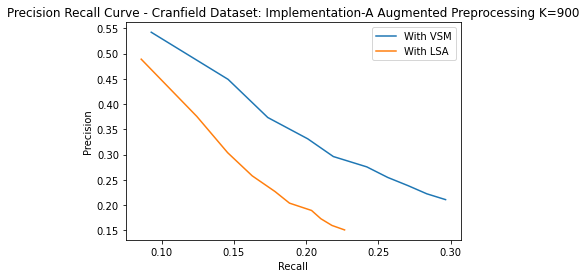

-----------------------------


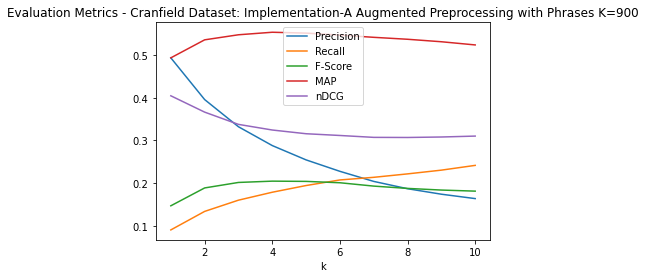

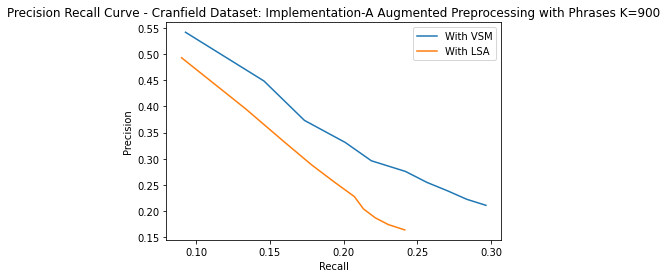

-----------------------------


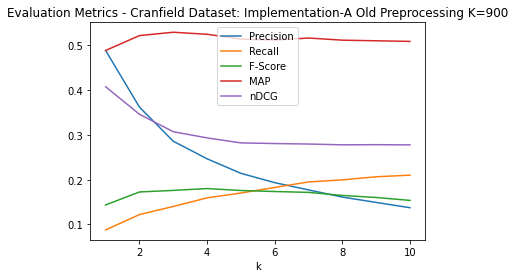

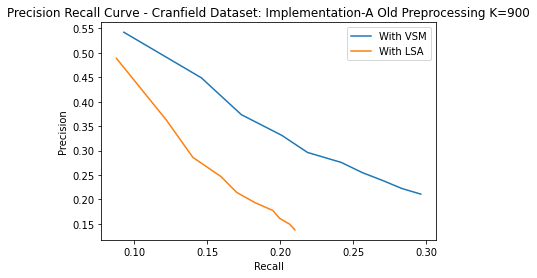

-----------------------------
The best K is  400
The Maximum MAP is  0.6107530864197533
Best implementation Implementation-A
Best doc Augmented Preprocessing with Phrases


In [63]:
## PLOTS FOR IMPLEMENTATION A

Implementation-A Augmented Preprocessing


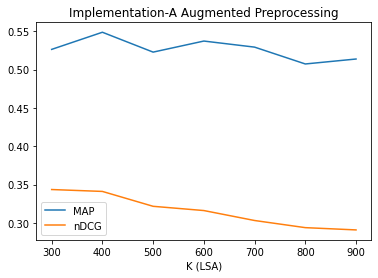

Implementation-A Augmented Preprocessing with Phrases


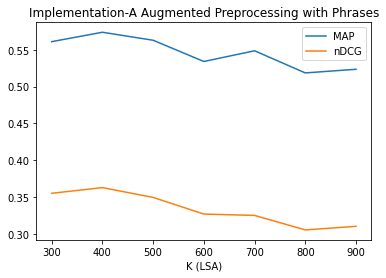

Implementation-A Old Preprocessing


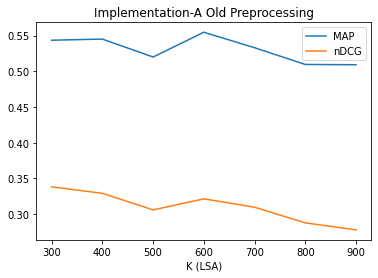

In [65]:
## PLOTS FOR IMPLEMENTATION A

# for i in range(len(k_dic)):
#   title = '{} {}'.format(implementation_string[i], doc_string[i])
#   print(title)
#   plt.plot(K, k_dic[i][0], label="MAP")
#   plt.plot(K, k_dic[i][1], label="nDCG")
#   plt.title(title)
#   plt.xlabel("K (LSA)")
#   plt.legend()
#   plt.show()

Implementation-1 Augmented Preprocessing


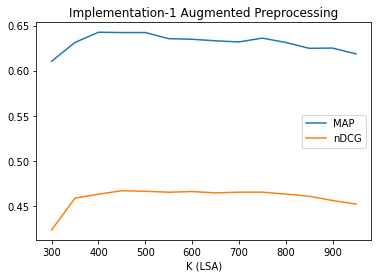

Implementation-1 Augmented Preprocessing with Phrases


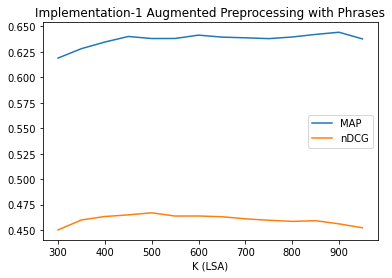

Implementation-1 Old Preprocessing


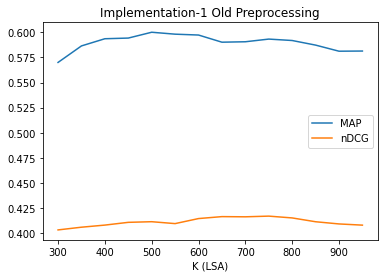

Implementation-2 Augmented Preprocessing


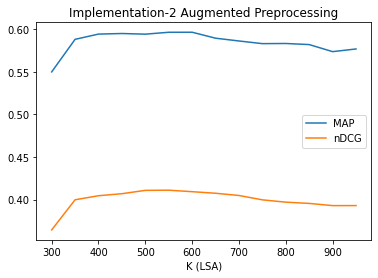

Implementation-2 Augmented Preprocessing with Phrases


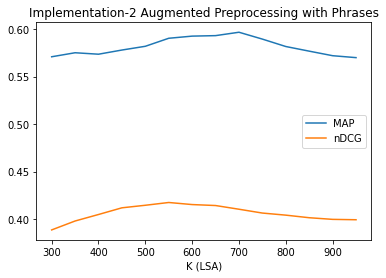

Implementation-2 Old Preprocessing


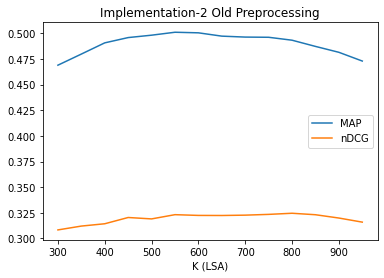

In [ ]:
# PLOTTING MAP@10 AND NDCG@10 FOR VARIOUS Ks FOR ALL 9 CASES
# CASE 0: LSA IMPLEMENTATION-A AUGMENTED TOKENIZATION
# CASE 1: LSA IMPLENTATION-A AUGMENTED TOKENIZATION WITH PHRASES
# CASE 2: LSA IMPLENTATION-A OLD PREPROCESSING
# CASE 3: LSA IMPLEMENTATION-1 AUGMENTED TOKENIZATION
# CASE 4: LSA IMPLENTATION-1 AUGMENTED TOKENIZATION WITH PHRASES
# CASE 5: LSA IMPLENTATION-1 OLD PREPROCESSING
# CASE 6: LSA IMPLEMENTATION-2 AUGMENTED TOKENIZATION
# CASE 7: LSA IMPLENTATION-2 AUGMENTED TOKENIZATION WITH PHRASES
# CASE 8: LSA IMPLENTATION-2 OLD PREPROCESSING

for i in range(len(k_dic)):
  title = '{} {}'.format(implementation_string[i], doc_string[i])
  print(title)
  plt.plot(K, k_dic[i][0], label="MAP")
  plt.plot(K, k_dic[i][1], label="nDCG")
  plt.title(title)
  plt.xlabel("K (LSA)")
  plt.legend()
  plt.show()

# Additional Exploration

Text(0.5, 1.0, 'Distribution of Number of Relevant Docs for Each query')

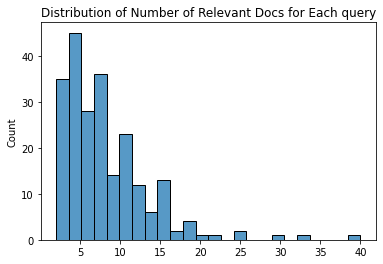

In [ ]:
len_rel = []
for query in query_ids:
  gt = get_ground_truth(query, qrels)
  len_rel.append(len(gt))
sns.histplot(len_rel)
plt.title("Distribution of Number of Relevant Docs for Each query")

Text(0.5, 1.0, 'Number of Relevant Docs for Each query')

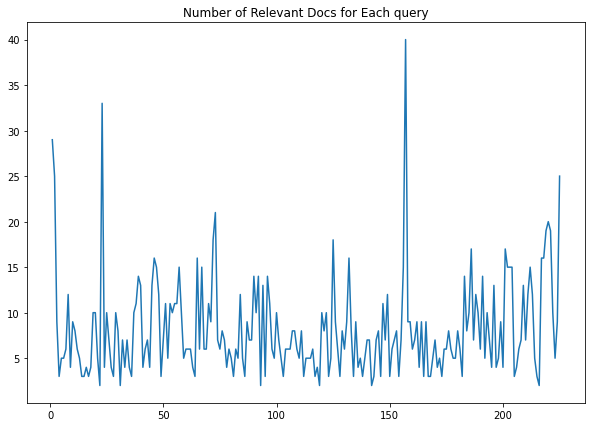

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(1,226), len_rel)
plt.title("Number of Relevant Docs for Each query")

Text(0.5, 1.0, 'Document ID vs number of queries the document is relevant to')

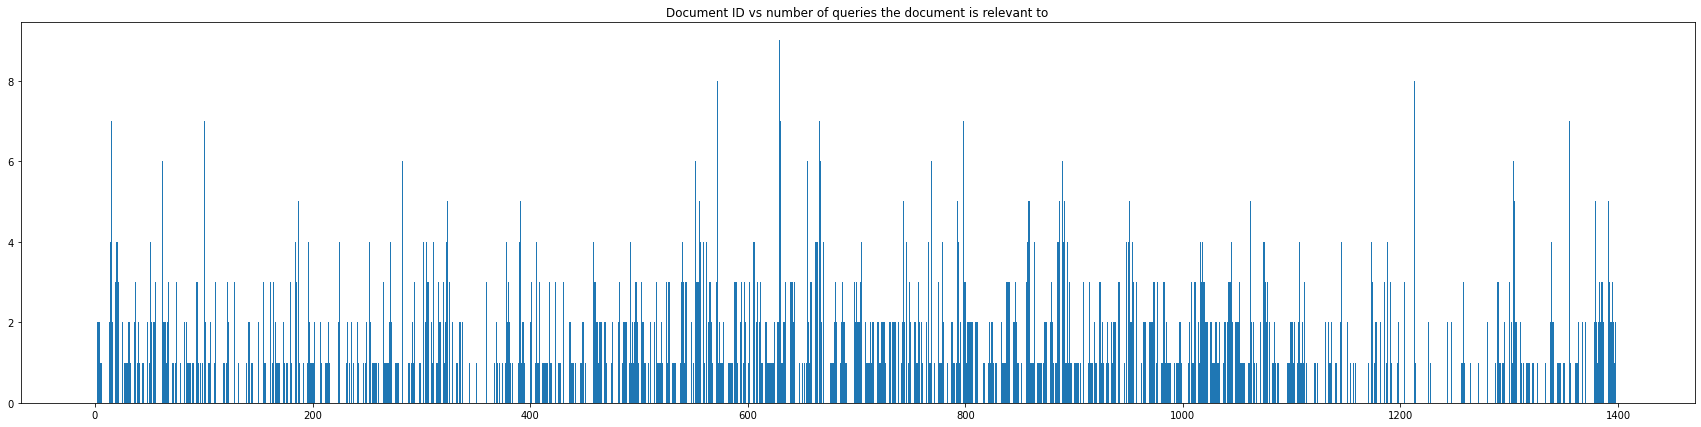

In [ ]:
rel = []
for query in query_ids:
  gt = get_ground_truth(query, qrels)
  rel.append((gt))
rel_count = dict(sum((Counter(e) for e in rel), Counter()))
keys = rel_count.keys()
values = rel_count.values()
plt.figure(figsize=(30,7))
plt.bar(keys, values)
plt.title("Document ID vs number of queries the document is relevant to")

In [ ]:
# DOCUMENT IDs WITH NUMBER OF QUERIES THE DOCUMENT IS RELEVANT TO
sorted(rel_count.items(), key = lambda x:x[1], reverse=True)

[(629, 9),
 (572, 8),
 (1213, 8),
 (15, 7),
 (24, 7),
 (798, 7),
 (1355, 7),
 (101, 7),
 (630, 7),
 (666, 7),
 (12, 6),
 (552, 6),
 (283, 6),
 (570, 6),
 (62, 6),
 (655, 6),
 (1304, 6),
 (667, 6),
 (769, 6),
 (889, 6),
 (859, 5),
 (858, 5),
 (391, 5),
 (1379, 5),
 (793, 5),
 (187, 5),
 (556, 5),
 (324, 5),
 (1391, 5),
 (887, 5),
 (888, 5),
 (891, 5),
 (951, 5),
 (743, 5),
 (843, 5),
 (1062, 5),
 (1305, 5),
 (184, 4),
 (378, 4),
 (51, 4),
 (14, 4),
 (746, 4),
 (948, 4),
 (285, 4),
 (390, 4),
 (857, 4),
 (864, 4),
 (492, 4),
 (20, 4),
 (58, 4),
 (354, 4),
 (196, 4),
 (21, 4),
 (302, 4),
 (160, 4),
 (311, 4),
 (705, 4),
 (406, 4),
 (225, 4),
 (252, 4),
 (672, 4),
 (272, 4),
 (557, 4),
 (305, 4),
 (663, 4),
 (797, 4),
 (794, 4),
 (562, 4),
 (1339, 4),
 (779, 4),
 (388, 4),
 (664, 4),
 (323, 4),
 (662, 4),
 (540, 4),
 (458, 4),
 (421, 4),
 (670, 4),
 (606, 4),
 (559, 4),
 (1104, 4),
 (766, 4),
 (894, 4),
 (605, 4),
 (890, 4),
 (1146, 4),
 (885, 4),
 (886, 4),
 (950, 4),
 (1016, 4),
 (1018, 

In [ ]:
# GETTING TOP-10 MOST FREQUENT WORDS
corpus_dict = {"corpus":corpus} #corpus contains combined text from all queries and documents
fi_corpus = convert_list_to_dict(corpus_dict, docs_or_queries = True)
corpus_tokens_dict = get_all_tokens(fi_corpus, with_occurence = True)
token_df = pd.DataFrame({"token":corpus_tokens_dict.keys(), "frequency":corpus_tokens_dict.values()}) #dataframe containing all tokens and their occurences in corpus
freq_df = token_df.sort_values(by='frequency', ascending=False)
freq_df.head(10)

token  frequency
25       flow       2138
52   pressure       1387
365    number       1358
178  boundary       1244
179     layer       1190
126    result       1079
93     effect        962
62     method        909
188    theory        900
68       body        876

In [ ]:
# GETTING ALL WORDS WHICH OCCUR ONLY ONCE IN ALL DOCUMENTS AND QUERIES
freq_df.loc[freq_df['frequency']==1]

token  frequency
6093     negation          1
7259          age          1
6160    radkowski          1
6017   heywoodr.b          1
7258  aerothermal          1
...           ...        ...
4610       gothic          1
4612   woodleyj.g          1
4614  electroform          1
4616   catheralld          1
7568           ob          1

[3402 rows x 2 columns]

In [ ]:
# GETTING TOP-10 LEAST FREQUENT WORDS
freq_df.tail(10)

token  frequency
4604     affinely          1
4605   lardnert.j          1
4606   doylem.d.c          1
4608         east          1
4609   sellsc.c.l          1
4610       gothic          1
4612   woodleyj.g          1
4614  electroform          1
4616   catheralld          1
7568           ob          1

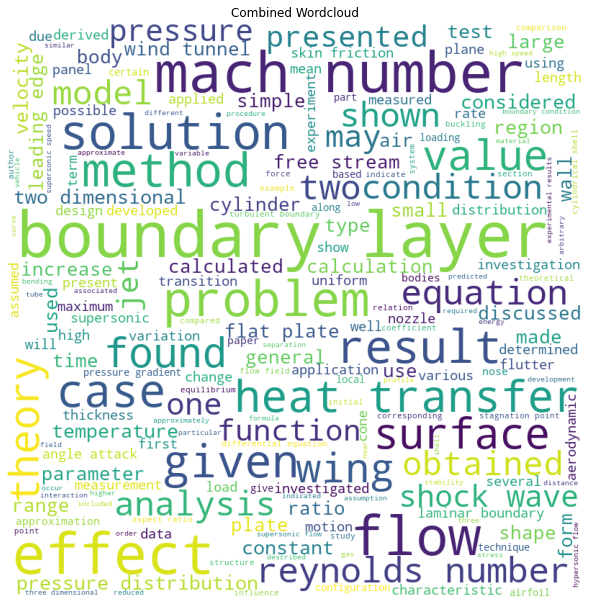

In [ ]:
# WORDCLOUD FOR ENTIRE CORPUS
doc_corpus = " ".join(docs)
query_corpus = " ".join(queries)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(corpus)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Combined Wordcloud")
plt.show()